In [91]:
import os
import pickle
import numpy as np
import pandas as pd
from rcmd import MF_Mean_Model

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf

from tensorboard.plugins import projector

import seaborn as sns
import matplotlib.pyplot as plt

import gdown
from IPython.display import clear_output

pd.options.display.float_format = "{:.5f}".format

dataset_path = os.environ.get('RCMD_DATASET_PATH', '../dataset')
print('Dataset path', dataset_path)
model_path = os.environ.get('RCMD_MODEL_PATH', '../model')
print('Model path', model_path)
log_path = os.environ.get('RCMD_LOG_PATH', '../logs')
print('Log path', log_path)

Dataset path ../dataset
Model path ../model
Log path ../logs


In [92]:
# GPU의 메모리를 충분히 확보할 수 있도록 세팅을  합니다.
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print("{} Physical GPUs, {} Logical GPUs".format(len(gpus), len(logical_gpus)))
    except RuntimeError as e:
        print(e)
%load_ext tensorboard

1 Physical GPUs, 1 Logical GPUs
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# 임베딩 기반 방법의 문제점

## 1. Cold Start Problem

데이터가 충분하지 않은 요소에 대해서는 정확도가 떨어집니다.

- 추천 문제에 있어서는 신규 사용자와 아이템에 대한 예측의 정확도가 현저하게 떨어집니다.

### 추천 모델 검증의 설계 

추천 모델은 **확보한 데이터**를 바탕으로 **이후의** 사용자들의 아이템에 대한 선호도의 순위(Ranking)을 구하게 됩니다. 

임베딩의 내용은 학습 과정에서 만들어집니다. 

학습 데이터에서 등장하지 않거나, 

충분히 데이터가 쌓이지 않은 요소의 임베딩은 대상의 특징을 제대로 나타내지 못합니다.

→ 이 점을 고려하여 추천 모델은 시점 기준으로 분리하여 이전 시점을 학습 데이터로, 이후의 시점의 데이터를 검증 데이터로 구성

**시점 기준의 분리**를 사용하여, 

실제 추천 모델이 동작하는 상황을 고려하여 임의 분리 보다 신뢰도가 높은 검증 설계를 합니다.

In [93]:
# MovieLens 100K를 데이터셋을 불러옵니다.

df_ratings = pd.read_csv(os.path.join(dataset_path, 'ratings_100k.csv'))
df_ratings['date'] = df_ratings.pop('timestamp').pipe(lambda x: pd.to_datetime(x, unit='s'))
df_user = pd.read_csv(os.path.join(dataset_path, 'users_100k.csv'), index_col='user id')
df_movie = pd.read_csv(os.path.join(dataset_path, 'movies_100k.csv'), index_col='movie id')

In [94]:
# 시점을 기준으로 나누어 Test에는 Train에 등장하지 않은 사용자와 영화가 배치되도록 합니다.
df_train = df_ratings.query('date < "1998-03-01"')
df_valid = df_ratings.query('date >= "1998-03-01"')

ds_train = tf.data.Dataset.from_tensor_slices(
    ({i: df_train[i] for i in ['item id', 'user id']}, df_train['rating'])
)

ds_valid = tf.data.Dataset.from_tensor_slices(
    ({i: df_valid[i] for i in ['item id', 'user id']}, df_valid['rating'])
)

In [95]:
print(
    "학습 데이터수: {}, 검증 데이터수: {}".format(len(df_train), len(df_valid))
)
print(
    "학습 데이터의 기간:", df_train['date'].agg(['min', 'max']).dt.strftime('%Y-%m-%d').str.cat(sep='~')
)
print(
    "검증 데이터의 기간:", df_valid['date'].agg(['min', 'max']).dt.strftime('%Y-%m-%d').str.cat(sep='~')
)

학습 데이터수: 77985, 검증 데이터수: 22015
학습 데이터의 기간: 1997-09-20~1998-02-28
검증 데이터의 기간: 1998-03-01~1998-04-22


In [96]:
# Test에서 Train에 등장하지 사용자의 평가의 비율

print("Test에서 신규 사용자의 평점 비율: {:.5f}, 사용자 수: {}".format(
    (~df_valid['user id'].isin(df_train['user id'].unique())).mean(), 
    len(set(df_valid['user id'].unique()) - set(df_train['user id'].unique()))
))

print("Test에서 신규 영화의 평점 비율: {:.5f}, 영화의 수: {}".format(
    (~df_valid['item id'].isin(df_train['item id'].unique())).mean(), 
    len(set(df_valid['item id'].unique()) - set(df_train['item id'].unique()))
))

Test에서 신규 사용자의 평점 비율: 0.82689, 사용자 수: 207
Test에서 신규 영화의 평점 비율: 0.00999, 영화의 수: 74


- MovieLens 100K 신규 유저를 중심으로 평점이 구성 됩니다.
- MovieLens의 추천 시스템은 신규 유저에 대한 정확도를 높이는 것이 중요하다고 판단됩니다.

임베딩 기반 방법인 MF_Mean_Model은 검증 결과는 좋지 않을 것으로 예상 됩니다.

In [97]:
mf_mean_model = MF_Mean_Model(
    df_train['user id'].value_counts().pipe(lambda x: x.loc[x > 1]).index.tolist(), # 등장 빈도가 1회를 넘는 사용자에 대해 임베딩을 부여
    df_train['item id'].value_counts().pipe(lambda x: x.loc[x > 1]).index.tolist(), # 등장 빈도가 1회를 넘는 영화에 대해 임베딩을 부여
    df_train['rating'].mean(), 
    16
)
tf.keras.backend.clear_session()
mf_mean_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.004),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanSquaredError()]
)

In [98]:
history = mf_mean_model.fit(
    ds_train.shuffle(100000).batch(256), validation_data=ds_valid.batch(1024), epochs=20, verbose = 1
)

Epoch 1/20
305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.0672 - mean_squared_error: 1.0672 - val_loss: 1.1144 - val_mean_squared_error: 1.1144
Epoch 2/20
305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.8052 - mean_squared_error: 0.8052 - val_loss: 1.0710 - val_mean_squared_error: 1.0710
Epoch 3/20
305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.6734 - mean_squared_error: 0.6734 - val_loss: 1.0667 - val_mean_squared_error: 1.0667
Epoch 4/20
305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.5889 - mean_squared_error: 0.5889 - val_loss: 1.0749 - val_mean_squared_error: 1.0749
Epoch 5/20
305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.5349 - mean_squared_error: 0.5349 - val_loss: 1.0796 - val_mean_squared_error: 1.0796
Epoch 6/20
305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4993 - mean_squared_error: 0.4993 - val_loss: 1.0865 - val_mean_squared_error: 1.0865
Epoch 7/20
305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4749 - mean_squared_error: 0.4749 - val_loss: 1.09

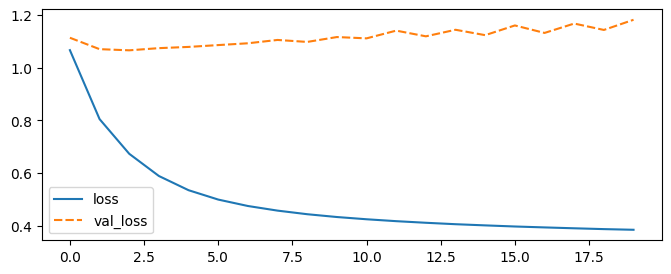

In [99]:
plt.figure(figsize = (8, 3))
pd.DataFrame(history.history).drop(
    columns = ['mean_squared_error', 'val_mean_squared_error']
).pipe(
    lambda x: sns.lineplot(x)
)
plt.show()

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


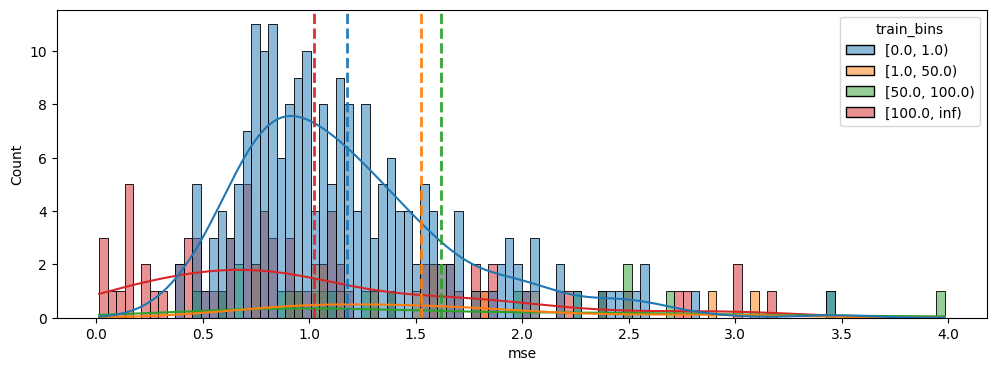

In [100]:
from sklearn.metrics import mean_squared_error

# 사용자별 MSE
s_mse = (
    df_valid.assign(
        rating_hat=np.squeeze(mf_mean_model.predict(ds_valid.batch(1024)))
    )
    .groupby("user id")
    .apply(lambda x: mean_squared_error(x["rating"], x["rating_hat"]), include_groups=False)
    .rename("mse")
)

# user별 train/test count + mse + binning
x = (
    pd.concat(
        [
            df_train["user id"].value_counts().rename("train count"),
            df_valid["user id"].value_counts().rename("test count"),
            s_mse,
        ],
        axis=1,
    )
    .pipe(lambda t: t.loc[t["test count"].notna()])
    .fillna(0)
    .assign(
        train_bins=lambda t: pd.cut(
            t["train count"], bins=[0, 1, 50, 100, np.inf], right=False
        )
    )
)
plt.figure(figsize = (12, 4))
# hue 순서/팔레트 고정 (색 매칭을 위해 중요)
hue_order = list(x["train_bins"].cat.categories)  # Interval 카테고리 순서 그대로
palette = sns.color_palette(n_colors=len(hue_order))

ax = sns.histplot(
    data=x, x="mse", hue="train_bins", hue_order=hue_order, palette=palette, bins=100, kde=True,
)

# 구간별 평균 MSE 세로선(색 매칭) + 텍스트 표시
means = x.groupby("train_bins", observed = True)["mse"].mean().reindex(hue_order)

y_top = ax.get_ylim()[1]
for (bin_label, mean_val), color in zip(means.items(), palette):
    if pd.notna(mean_val):
        ax.axvline(mean_val, color=color, linestyle="--", linewidth=2, alpha=0.95)

plt.show()

In [101]:
pd.concat(
    [
        df_train["user id"].value_counts().rename("train count"),
        df_valid["user id"].value_counts().rename("test count"),
        s_mse,
    ],
    axis=1,
).pipe(lambda t: t.loc[t["test count"].notna()]).fillna(0).assign(
    train_bins=lambda t: pd.cut(
        t["train count"], bins=[0, 1, 25, 50, np.inf], right=False
    )
)['train_bins'].value_counts()

train_bins
[0.0, 1.0)      207
[50.0, inf)      99
[25.0, 50.0)     12
[1.0, 25.0)       9
Name: count, dtype: int64

## 2. 지속적인 재학습 필요

사용자, 아이템이 추가될 때마다, 모델을 재구성해줘야 하고

새로운 데이터로 재학습을 시켜줘야 합니다.




**Cold Start Problem** 과 **주기적 재학습** 문제에 해결하기 위해 등장한 방법들을 확인해 봅니다.


In [102]:
del df_train, df_valid, ds_train, ds_valid

# MovieLens32M 데이터 준비

대규모 데이터셋을 사용합니다.

In [103]:
# 영화 메타데이터를 가져옵니다. (한국어 버전)
with open(os.path.join(dataset_path, 'tmdb_movie_info_kr.pkl'), 'rb') as f:
    dic_movie_info_kr = pickle.load(f)

# OpenAI의 Embedding API를 통해 구한 영화 타이틀과 줄거리의 Embedding 데이터를 불러 옵니다. (영어 버전)
with open(os.path.join(dataset_path, 'tmdb_movie_emb.pkl'), 'rb') as f:
    movie_info_emb = pickle.load(f)

In [104]:
# 평점을 불러옵니다.
df_ratings = pd.read_parquet(os.path.join(dataset_path, 'ratings.parquet'))
# 일자를 timestamp 형식(Integer)에서 일자형식으로 바꿉니다.
df_ratings['date'] = df_ratings.pop('timestamp').pipe(lambda x: pd.to_datetime(x, unit='s'))
# 평점수, 영화수, 사용자수
len(df_ratings), df_ratings['movieId'].nunique(), df_ratings['userId'].nunique()

(32000204, 84432, 200948)

In [105]:
df_ratings.head()

,userId,movieId,rating,date
0,1,17,4.00000,1999-12-03 19:24:37
1,1,25,1.00000,1999-12-03 19:43:48
2,1,29,2.00000,1999-11-22 00:36:16
3,1,30,5.00000,1999-12-03 19:24:37
4,1,32,5.00000,1999-11-22 00:00:58


In [106]:
# 영화의 간략 버젼의 메타데이터를 불러옵니다.
df_movie = pd.read_csv(os.path.join(dataset_path, 'movies.csv'), index_col='movieId')

# 영화 출시일을 영화 메타데이터에서 가져옵니다.
df_movie['release_date'] = df_movie.index.map(
    lambda x: dic_movie_info_kr.get(x, {'release_date': None}).get('release_date', None)
).values
df_movie['release_date'] = pd.to_datetime(df_movie['release_date'] )

# 결측일 경우 평점 데이터에서 가장 먼저 출현한 시점으로 잡습니다.
s_date_fillna = df_ratings.loc[
    df_ratings['movieId'].isin(df_movie.loc[df_movie['release_date'].isna()].index)
].groupby('movieId')['date'].min()
df_movie.loc[df_movie.index.isin(s_date_fillna.index), 'release_date'] = pd.to_datetime(s_date_fillna)
df_movie = df_movie.dropna()
df_movie['release_date'] = df_movie['release_date'].astype('int64')

# 영화 개봉 시점과 평가 시점 간의 경과 시간을 뺄셈 연산으로 구하기 위해 Timestamp단위로 저장합니다.
df_ratings['ts'] = df_ratings['date'].astype('int64')
display(df_movie.head())
df_movie.shape

,title,genres,release_date
movieId,,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,815011200000000000
2,Jumanji (1995),Adventure|Children|Fantasy,818985600000000000
3,Grumpier Old Men (1995),Comedy|Romance,819590400000000000
4,Waiting to Exhale (1995),Comedy|Drama|Romance,819590400000000000
5,Father of the Bride Part II (1995),Comedy,818380800000000000


(87561, 3)

In [107]:
# 사용자가 이전 시점에 평가한 이력을 만들기 위해 userId와 date로 정렬합니다.
df_ratings.sort_values(['userId', 'date'], inplace=True)

In [108]:
# 바로 이전에 시청한 내역을 구하여 prev_movieId, prev_rating에 넣습니다.
df_ratings[['prev_movieId', 'prev_rating', 'prev_ts']] = df_ratings[['movieId', 'rating', 'ts']].shift(1)
df_ratings['prev_movieId'] = df_ratings['prev_movieId'].fillna(0).astype('int')
# 현 시점의 사용자와 이전에 시청한 이력의 사용자가 다를 경우에는 이전 시청 이력이 없는 것입니다.
# 시청이력이 없음을 prev_movieId와 prev_rating를 0으로 나타냅니다.
df_ratings.loc[df_ratings['userId'] != df_ratings['userId'].shift(1), ['prev_movieId', 'prev_rating', 'prev_ts']] = [0, np.nan, np.nan]
df_ratings['prev_ts'] = df_ratings['prev_ts'].fillna(df_ratings['ts']).astype('int64')

In [109]:
# 2019-01-01 이전은 학습셋, 2019-01-01 이후는 평가셋으로 나눕니다.
# sample(frac=1) 시점에 대해 정렬된 데이터를 섞어 Batch Gradient Descent시 시점에 대한 치우침 문제가 발생하지 않도록 합니다.
df_train = df_ratings.loc[df_ratings['date'] < '2022-10-13'].sample(frac=1).copy()
df_test = df_ratings.loc[df_ratings['date'] >= '2022-10-13'].copy()
# 학습과 평가 데이터에 비율을 구합니다.
len(df_train) / len(df_ratings), len(df_test) / len(df_ratings)

(0.9690947907707088, 0.030905209229291162)

In [110]:
rating_train_mean = df_train['rating'].astype('float64').mean()
# 이전 평점이 없는 경우 학습 데이터에서의 평균 평점으로 대체합니다.
df_train['prev_rating'] = df_train['prev_rating'].fillna(rating_train_mean)
# 이전 평점이 없는 경우 학습 데이터에서의 평균 평점으로 대체합니다.
df_test['prev_rating'] = df_test['prev_rating'].fillna(rating_train_mean)
df_test.sort_index()

,userId,movieId,rating,date,ts,prev_movieId,prev_rating,prev_ts
2184,22,745,5.00000,2022-11-20 02:04:50,1668909890000000000,1148,5.00000,1668909874000000000
2185,22,1036,3.50000,2023-01-21 20:48:01,1674334081000000000,79132,4.00000,1674334027000000000
2187,22,1148,5.00000,2022-11-20 02:04:34,1668909874000000000,93840,4.50000,1668909780000000000
2196,22,2762,3.50000,2022-11-19 22:04:32,1668895472000000000,202439,4.50000,1650330174000000000
2203,22,5989,3.50000,2023-01-21 20:48:37,1674334117000000000,6936,4.00000,1674334105000000000
...,...,...,...,...,...,...,...,...
31997966,200933,275245,2.00000,2022-11-04 07:58:39,1667548719000000000,274343,2.50000,1653641400000000000
31997967,200933,278446,3.50000,2023-03-12 06:14:36,1678601676000000000,122906,2.50000,1667548748000000000
31997968,200933,280866,4.00000,2023-03-12 06:16:38,1678601798000000000,278446,3.50000,1678601676000000000
31997969,200933,281188,4.50000,2023-04-16 07:52:32,1681631552000000000,1244,4.00000,1678602082000000000


In [111]:
# 사용자별 평가수를 구합니다.
s_userCnt = df_train['userId'].value_counts()
# 영화별 평가수를 구합니다.
s_movieCnt = df_train['movieId'].value_counts()

In [112]:
# pd.DataFrame을 tf.Dataset으로 바꾸어 줍니다.
# (Dictionary, List) 형태의 튜플로 구성됩니다.
# 입력변수는 userId, movieId, prev_movieId, prev_rating
# 입력 변수는 Model에 전달될 때, 키 값이 userId, movieId, prev_movieId, prev_rating인 Dictionary 형태로 전달이됩니다.
# 대상변수는 rating입니다.
def to_dataset(df):
    return tf.data.Dataset.from_tensor_slices(
        ({k: df[k] for k in ['userId', 'movieId', 'ts', 'prev_movieId', 'prev_rating', 'prev_ts']}, 
         df['rating'])
    )

In [113]:
# Tensorflow dataset을 만들어 줍니다.
# Tensorflow dataset을 활용하는 이유
# 1. fit에 DataFrame을 직접전달 할 때에는 메모리의 Gabage들이 발생할 수 있습니다. Dataset을 사용하면 발생확률을 낮춰줍니다.
# 2. Batch와 Shuffle등 dataset관련 연산을 활용할 수 있습니다.
# 즉, 안정적으로 모델 검증 작업을 이어가기 위해 사용합니다.
ds_train = to_dataset(df_train)
ds_test = to_dataset(df_test)

In [114]:
# Tensorflow 데이터셋의 내용을 살펴 봅니다.

# batch_size 32개가 되도록하고, 첫 번째 배치만 출력합니다, 
for X, y in ds_train.take(1):
    print(X, y)

{'userId': <tf.Tensor: shape=(), dtype=int64, numpy=176842>, 'movieId': <tf.Tensor: shape=(), dtype=int64, numpy=1619>, 'ts': <tf.Tensor: shape=(), dtype=int64, numpy=994292948000000000>, 'prev_movieId': <tf.Tensor: shape=(), dtype=int64, numpy=1586>, 'prev_rating': <tf.Tensor: shape=(), dtype=float64, numpy=2.0>, 'prev_ts': <tf.Tensor: shape=(), dtype=int64, numpy=994292948000000000>} tf.Tensor(4.0, shape=(), dtype=float16)


2025-12-16 10:56:10.485312: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# 기반 모델

모델을 고도화 함에 따라 모델의 복잡도 또한 같이 커지게 됩니다.

모듈화를 통해 복잡한 모델을 효과적으로 구성할 수 있도록 기반 모델들을 만들어 모듈러하게 모델들을 빌드업 합니다.

### Embedding Model

정수 엔터티의 ID에서 위치 인덱스를 반환하는 IntegerLookup Layer과 임베딩을 연결하는 것은 많이 쓰여 이를 tf.keras.Model로 모듈화 합니다.

**모델 구조**

```mermaid
flowchart LR
    id((ID))
    subgraph EmbModel["EmbModel(ids, size)"]
        subgraph ILL[IntegerLookup]
            voc["vocabulary: ids"]
        end
        subgraph Emb[Embedding]
            tab["Tensor (ids 수 + 1)xsize"]
        end
        ILL-->|N|Emb
    end
    output(ID의 Embedding)
    id -->|N| ILL
    Emb --> |Nxsize| output

    %% class definitions
    classDef layer fill:#E3F2FD,stroke:#1E88E5,stroke-width:1px,color:#0D47A1
    classDef trainable fill:#E8F5E9,stroke:#2E7D32,stroke-width:1px,color:#1B5E20
    classDef nontrainable fill:#FCE4EC,stroke:#C2185B,stroke-width:1px,color:#880E4F

    %% class assignments
    class ILL,Emb layer
    class tab trainable
    class voc nontrainable
```

In [115]:
class EmbModel(tf.keras.Model):
    """
    ID를 임베딩 벡터로 변환하는 기본 모델
    
    정수형 ID(사용자 ID, 영화 ID 등)를 고정 크기의 임베딩 벡터로 변환합니다.
    """
    def __init__(self, ids, size, l2=0):
        """
        Args:
            ids (list): 변환할 ID 목록 (예: [1, 2, 3, ...])
            size (int): 임베딩 벡터의 차원 수
            l2 (float): L2 정규화 계수 (0이면 정규화 없음)
        """
        super().__init__()
        
        # ID를 인덱스로 변환하는 레이어 (0은 OOV - Out Of Vocabulary)
        self.lu_ids = tf.keras.layers.IntegerLookup(
            vocabulary=tf.constant(ids)
        )
        
        # L2 정규화 설정
        if l2 > 0:
            reg = tf.keras.regularizers.L2(l2)
        else:
            reg = None
            
        # 인덱스를 임베딩 벡터로 변환하는 레이어
        self.emb = tf.keras.layers.Embedding(
            len(ids) + 1,  # +1은 OOV를 위한 공간
            size, 
            embeddings_regularizer=reg
        )
        self.output_size = size

    def build(self):
        """레이어들을 초기화합니다"""
        input_shape = (None, 1)
        # 1. Lookup 레이어 build
        self.lu_ids.build(input_shape)
    
        # 2. Lookup 후 Embedding 레이어 shape 계산
        lu_shape = self.lu_ids.compute_output_shape(input_shape)
    
        # 3. Embedding 레이어 build
        self.emb.build(lu_shape)
    
    def call(self, x, training=False):
        """
        x에 대한 임베딩 반환
        
        Args:
            x: ID 텐서 (N, 1) 형태
            training: 학습 모드 여부
            
        Returns:
            임베딩 벡터 (N, size) 형태
        """
        x = self.lu_ids(x)  # 정수형 ID(N×1) → Embedding Index (N×1)
        return self.emb(x, training=training)  # Embedding Index → 임베딩 벡터 (N×size)

### Mean Model

EmbModel을 사용하여 평균 모델을 구성합니다.

**모델 구조**

```mermaid
%%{init: {
  "flowchart": {
    "nodeSpacing": 30
  }
}}%%
flowchart LR
    uId(userId)
    mId(movieId)
    subgraph mm["<div style='white-space:nowrap;'>MeanModel(userId 리스트, movieId 리스트)</div>"]
        subgraph u_m["user_mean:EmbModel"]
            sz1["ids: userId 리스트, size: 1"]
        end
        subgraph m_m["movie_mean:EmbModel"]
            sz2["ids: movieId 리스트, size: 1"]
        end
        Rw(+)
        m((mean))
    end
    
    output((Rating))
    uId-->|N|u_m
    mId-->|N|m_m
    u_m-->|Nx1|Rw
    m_m-->|Nx1|Rw
    m-->|1|Rw
    Rw-->|Nx1|output

    classDef layer fill:#E3F2FD,stroke:#1E88E5,stroke-width:1px,color:#0D47A1
    classDef trainable fill:#E8F5E9,stroke:#2E7D32,stroke-width:1px,color:#1B5E20
    classDef nontrainable fill:#FCE4EC,stroke:#C2185B,stroke-width:1px,color:#880E4F
    class Rw layer
    class m nontrainable
```

In [116]:
# 평균, 사용자 편향, 영화 편향을 모델링하는 Baseline 모델
class MeanModel(tf.keras.Model):
    """
    평균 기반 예측 모델 (Baseline)
    
    전체 평균 + 사용자 편향 + 영화 편향을 더해서 기본적인 평점을 예측합니다.
    예측식: rating = 전체평균 + 사용자편향 + 영화편향
    """
    def __init__(self, mean, user_ids, movie_ids):
        """
        Args:
            mean (float): 전체 평점 평균
            user_ids (list): 사용자 ID 목록
            movie_ids (list): 영화 ID 목록
        """
        super().__init__()
        
        self.mean = mean
        self.user_ids = user_ids
        self.movie_ids = movie_ids
        
        # 전체 평균을 상수로 저장
        self.mean_ = tf.constant([mean], dtype=tf.float32)
        
        # 사용자별 편향값 (크기 1인 임베딩)
        self.user_mean_model = EmbModel(user_ids, 1)
        
        # 영화별 편향값 (크기 1인 임베딩)
        self.movie_mean_model = EmbModel(movie_ids, 1)

    def build(self):
        """모델 초기화"""
        self.user_mean_model.build()
        self.movie_mean_model.build()

    def call(self, x, training=False):
        """
        평점 예측
        
        Args:
            x (dict): {'userId': 사용자ID, 'movieId': 영화ID}
            training: 학습 모드 여부
            
        Returns:
            예측 평점 = 전체평균 + 사용자편향 + 영화편향
        """
        return self.mean_ + \
            self.user_mean_model(x['userId'], training=training) + \
            self.movie_mean_model(x['movieId'], training=training)

    def get_model_data(self):
        """모델 가중치와 설정을 딕셔너리로 반환"""
        return {
            'mean': self.mean,
            'user_ids': self.user_ids,
            'movie_ids': self.movie_ids,
            'user_mean_model': self.user_mean_model.get_weights(),
            'movie_mean_model': self.movie_mean_model.get_weights()
        }

    def from_model_data(model_data):
        """저장된 모델 데이터로부터 모델 복원"""
        model = MeanModel(
            model_data['mean'], model_data['user_ids'], model_data['movie_ids']
        )
        model.build()
        model.user_mean_model.set_weights(model_data['user_mean_model'])
        model.movie_mean_model.set_weights(model_data['movie_mean_model'])
        return model
    
    def predict_by_userid(self, x):
        """
        한 사용자에 대한 여러 영화의 평점을 한번에 예측
        
        call()은 (사용자1, 영화1), (사용자2, 영화2) 형태의 pair 예측이지만,
        실제로는 한 사용자가 여러 영화를 평가하는 경우가 많으므로
        이를 최적화한 메서드입니다.
        
        Args:
            x (dict): {'userId': 사용자ID, 'movieIds': [영화ID 리스트]}
            
        Returns:
            예측 평점 배열
        """
        x_user = self.user_mean_model(
            x['userId'], # N
            training=False
        )
        # 단일 사용자 벡터와 여러 영화 벡터의 브로드캐스트 연산으로 계산량 감소
        x_movie = self.movie_mean_model(
            x['movieIds'], # N
            training=False
        )
        return tf.squeeze(x_user + x_movie + self.mean)

    def get_user_vec(self, user_id, **argv):
        """사용자 벡터 반환 (MeanModel에서는 편향을 나타내기 위해 1.0 반환)"""
        return tf.constant([1.0])

    def get_item_vecs(self, item_ids, **argv):
        """영화 벡터들 반환 (편향값)"""
        return self.movie_mean_model(
            tf.constant(item_ids)
        )

In [117]:
tf.keras.backend.clear_session()
mean_model = MeanModel(
    rating_train_mean, 
    s_userCnt.loc[s_userCnt > 1].index.values, 
    s_movieCnt.loc[s_movieCnt > 1].index.values
)
# mean_model의 동작을 확인합니다.
mean_model({'userId': tf.constant([1, 2]), 'movieId': tf.constant([1, 5])})

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[3.5373192],
       [3.5369978]], dtype=float32)>

### 가법 모델

가장 간단한 앙상블 모델로 여러 모델의 Output을 더하여 하나의 Output으로 만듭니다.

**모델 구조**

```mermaid
%%{init: {
  "flowchart": {
    "nodeSpacing": 30
  }
}}%%
flowchart LR
    input((Inputs))
    subgraph AM[AdditiveModel]
        direction LR
        m1[Model 1]
        m2[Model 2]
        mdot["..."]
        mn[Model N]
        Ra("reduce_sum(axis=-1)")
    end
    output((Rating))
    
    input-->AM
    m1-->|N|Ra
    m2-->|N|Ra
    mdot-->|N|Ra
    mn-->|N|Ra
    AM-->|N|output

    classDef layer fill:#E3F2FD,stroke:#1E88E5,stroke-width:1px,color:#0D47A1
    classDef trainable fill:#E8F5E9,stroke:#2E7D32,stroke-width:1px,color:#1B5E20
    classDef nontrainable fill:#FCE4EC,stroke:#C2185B,stroke-width:1px,color:#880E4F

    class Ra layer
```

In [118]:
# 제공한 모델 각각의 예측 결과를 더하는 모델을 만듭니다.
class AdditiveModel(tf.keras.Model):
    """
    여러 모델의 예측값을 합산하는 앙상블 모델
    
    여러 개의 서브 모델들의 예측값을 더해서 최종 예측을 만듭니다.
    예: MeanModel + MFModel 처럼 조합 가능
    예측식: rating = model1(x) + model2(x) + ... + modelN(x)
    """
    def __init__(self, models):
        """
        Parameters:
            models: list
                tf.keras.Model 객체로 이루진 리스트입니다.
        """
        super().__init__()
        self.models = models

    def build(self):
        """모든 서브 모델 초기화"""
        for i in self.models:
            i.build()

    def call(self, x, training=False):
        """
        모든 모델의 예측값을 합산
        
        Args:
            x: 입력 데이터
            training: 학습 모드 여부
            
        Returns:
            모든 모델의 예측값 합
        """
        # 각각의 모델에서 나온 출력을 모으기 위한 리스트 입니다.
        y_hat = []
        for i in self.models:
            y_hat.append(i(x, training=training))
        # tf.reduce_sum: 주어진 텐서의 합을 구해줍니다. axis = 0: 첫번째 차원(모델의 위치를 나타내는 차원)에 대한 합을 구합니다.
        return tf.reduce_sum(y_hat, axis=0)

    def predict_by_userid(self, x):
        """
        한 사용자에 대한 여러 영화 예측
        
        call()에서의 연산은 (사용자1, 아이템1), (사용자2, 아이템2), ... 의 쌍별 예측입니다.
        실제 모델은 사용자 단위로 다수의 아이템에 대한 예측을 하게 됩니다.
        이러한 상황을 고려한 더욱 최적화한 루틴으로,
        한명의 사용자에게 여러 개의 아이템의 평점을 예측합니다.
        """
        y_hat = []
        for i in self.models:
            y_hat.append(i.predict_by_userid(x))
        return tf.reduce_sum(y_hat, axis=0)
        
    def get_user_vec(self, user_id, **argv):
        """모든 모델의 사용자 벡터를 연결 (concatenate)"""
        return tf.concat(
            [i.get_user_vec(user_id, **argv) for i in self.models], axis=-1
        )

    def get_item_vecs(self, item_ids, **argv):
        """모든 모델의 영화 벡터들을 연결 (concatenate)"""
        return tf.concat(
            [i.get_item_vecs(item_ids, **argv) for i in self.models], axis=-1
        )

# 학습 및 성능 평가

**학습**

컴파일된 모델을 1 Epoch 단위로 Fit을 시켜, 

각 Epoch 별로 성능 평가를 하여, 학습이 진행됨에 따라 성능의 차이를 모니터링합니다.

**성능 평가**

Cold Start Problem 문제와 모델 주기적 재학습 문제가 어떤 양상으로 나타나는지 살펴봅니다.

그래서 train에서의 사용자/아이템의 등장횟수에 따라 각각을 그룹핑합니다.

각 그룹의 test의 성능이 어떻게 달라지는 지 확인해 봅니다.

In [119]:
from sklearn.metrics import mean_squared_error

def predict(a_model, ds, batch_size = 1024, verbose=True):
    return np.squeeze(a_model.predict(ds.batch(batch_size).prefetch(tf.data.AUTOTUNE), verbose= 1 if verbose else 0))

def train_rcmd_model(a_model, epoches, user_bins, movie_bins, batch_size=1024, prd_batch_size=4096, shuffle_buffer_size=100000, verbose=True, callbacks=[]):
    """
    모델을 입력 받아 학습을 시킵니다.
    학습데이터에 user id와 item id의 빈도수에 따라 평가데이터에서의 성능을 집계하여 DataFrame으로
    결과를 반환합니다.
    Parameters:
        a_model: tf.keras.model
            추천 모델
        epoches: int int
            최적화 과정의 반복횟수
        user_bins: list
            성능 측정시 사용자 평가 빈도 구간
        movie_bins: list
            성능 측정시 영화 평가 빈도 구간
        batch_size: int
            데이터셋 배치 사이즈
        shuffle_buffer_size: int
            Train Set을 섞어주는 버퍼 사이즈
        verbose: int
            진행 상황 출력
        callbacks: list
            fit 함수에 전달하고자 하는 callback 함수
    Returns: DataFrame
        사용자와 영화의 평가 빈도별 모델 검증 결과를 담은 DataFrame
    """
    # epoch 마다 결과를 기록해 놓을 list 입니다.
    mse_train = [] # 학습셋에 대한 mse
    mse_test = [] # 테스트셋에 대한 mse
    mse_by_userCnt = [] # 테스트셋에 대한 성능 사용자가 학습셋에 등장한 횟수에 따른 구간별 mse
    mse_by_movieCnt = [] # 테스트셋에 대한 성능 영화가 학습셋에 등장한 횟수에 따른 구간별 mse
    # 평가 데이터의 userId의 학습데이터의 출현 빈도를 구합니다.
    s_user_type = pd.cut(
        df_test['userId'].map(df_train['userId'].value_counts()).fillna(0), bins=user_bins, right=False
    ).rename('userCnt')
    # 평가 데이터의 movieId의 학습데이터의 출현 빈도를 구합니다.
    s_movie_type = pd.cut(
        df_test['movieId'].map(df_train['movieId'].value_counts()).fillna(0), bins=movie_bins, right=False
    ).rename('movieCnt')
    for epoch in range(epoches):
        # ds_train을 shuffle_buffer_size만큼 섞어서 batch_size만큼
        a_model.fit(ds_train.shuffle(shuffle_buffer_size).batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE), callbacks=callbacks)

        df_prds = pd.DataFrame({
            'rating': df_test['rating'],
            'prds': predict(a_model, ds_test, prd_batch_size, False)
        })

        # Train / Test의 성능을 측정하여 기록합니다.
        mse_train.append(mean_squared_error(df_train['rating'], predict(a_model, ds_train, prd_batch_size)))
        mse_test.append(mean_squared_error(df_test['rating'], df_prds['prds']))

        # Train에 등장한 사용자 빈도수 별로 구분하여 Test의 성능을 측정합니다.
        mse_by_userCnt.append(
            df_prds.groupby(s_user_type).apply(lambda x: mean_squared_error(x['rating'], x['prds']))
        )

        # Test에 등장한 영화의 빈도수 별로 구분하여 Test의 성능을 측정합니다.
        mse_by_movieCnt.append(
            df_prds.groupby(s_movie_type).apply(lambda x: mean_squared_error(x['rating'], x['prds']))
        )
        del df_prds

        # 사용자의 평점 빈도수 구분한 성능 측정결과와 영화의 평점 빈도수를 구분한 성능 측정결과를 합칩니다.
        df_result = pd.concat([
            pd.DataFrame({('', 'train'): mse_train, ('', 'test'): mse_test}),
            pd.concat(mse_by_userCnt, axis=1).pipe(
                lambda x: x.set_index(pd.MultiIndex.from_product([['userCnt'], x.index.tolist()]))
            ).T,
            pd.concat(mse_by_movieCnt, axis=1).pipe(
                lambda x: x.set_index(pd.MultiIndex.from_product([['movieCnt'], x.index.tolist()]))
            ).T
        ], axis=1)
        df_result.index = np.arange(1, len(df_result) + 1)
        df_result.name = 'epoch'
        if verbose:
            clear_output()
            display(df_result)
    return df_result

# mf: MeanModel + MFModel

### MFModel

사용자의 rank 크기의 임베딩을 만드는 user_model

영화의 rank 크기의 임베딩을 만드는 movie_model

각각의 임베딩을 서로 행단위로 내적을 하여 평점을 출력하는 모델을 만듭니다.

**모델 구조**

```mermaid
%%{init: {
  "flowchart": {
    "nodeSpacing": 35
  }
}}%%
flowchart LR
    subgraph I[inputs]
        uId(userId)
        mId(movieId)
    end
    subgraph mm["<div style='white-space:nowrap;'>MFModel(user_ids, movie_ids, rank)</div>"]
        subgraph u_m["user_model:EmbModel"]
            sz1["ids: user_ids, size:rank"]
        end
        subgraph m_m["movie_model:EmbModel"]
            sz2["<div style='white-space:nowrap;'>ids: movie_ids, size:rank</div>"]
        end
        Rw["Dot(axis=-1)"]
    end
    
    output((Rating))
    uId-->|N|u_m
    mId-->|N|m_m
    u_m-->|Nxrank|Rw
    m_m-->|Nxrank|Rw
    Rw-->|Nx1|output

    classDef layer fill:#E3F2FD,stroke:#1E88E5,stroke-width:1px,color:#0D47A1
    classDef trainable fill:#E8F5E9,stroke:#2E7D32,stroke-width:1px,color:#1B5E20
    classDef nontrainable fill:#FCE4EC,stroke:#C2185B,stroke-width:1px,color:#880E4F
    
    class Rw layer
    class u_m layer
    class m_m layer
    class sz1 trainable
    class sz2 trainable
```

In [120]:
# 사용자 임베딩 모델과 영화 임베딩 모델을 받아, Matrix Factorization 모델을 생성합니다.
# user_model과 movie_model은 model 파라미터로 받아들이면 재사용 할 수 있도록, 
# 파라미터화 할 수 있습니다.
class MFModel(tf.keras.Model):
    """
    기본 Matrix Factorization 모델
    
    사용자 벡터와 영화 벡터의 내적(dot product)으로 평점을 예측합니다.
    예측식: rating = user_vector · movie_vector
    """
    def __init__(self, user_ids, movie_ids, rank):
        """
        Parameters:
            user_ids - np.array
                사용자 ID
            movie_ids - np.array
                영화 ID
            rank - int
                임베딩 벡터의 차원 수 (랭크)
        """
        super().__init__()

        self.user_ids = user_ids
        self.movie_ids = movie_ids
        self.rank = rank
        
        # 사용자 임베딩 모델 (rank 차원 벡터로 변환)
        self.user_model = EmbModel(user_ids, rank)
        # 영화 임베딩 모델 (rank 차원 벡터로 변환)
        self.movie_model = EmbModel(movie_ids, rank)
        # axes = -1 로 설정하면 Row-wise(행별)로 내적 계산을 수행합니다.
        self.dot = tf.keras.layers.Dot(axes=-1)

    def build(self):
        """모델 초기화"""
        self.user_model.build()
        self.movie_model.build()

    def call(self, x, training=False):
        """
        평점 예측 (순전파)
        
        Args:
            x (dict): {'userId': 사용자ID, 'movieId': 영화ID}
            training: 학습 모드 여부
            
        Returns:
            예측 평점 = user_vector · movie_vector
        """
        x_user = self.user_model(x['userId'], training=training)
        x_movieId = self.movie_model(x['movieId'], training=training)
        return self.dot([x_user, x_movieId])

    def get_model_data(self):
        """모델 가중치와 설정을 딕셔너리로 반환 (저장용)"""
        return {
            'user_ids': self.user_ids,
            'movie_ids': self.movie_ids,
            'user_model': self.user_model.get_weights(),
            'movie_model': self.movie_model.get_weights(),
            'rank': self.rank
        }

    def from_model_data(model_data):
        """저장된 모델 데이터로부터 모델 복원"""
        model = MFModel(
            model_data['user_ids'], model_data['movie_ids'], model_data['rank']
        )
        model.build()
        model.user_model.set_weights(model_data['user_model'])
        model.movie_model.set_weights(model_data['movie_model'])
        return model

    def predict_by_userid(self, x):
        """
        한 사용자에 대한 여러 영화의 평점을 한번에 예측
        
        call()에서의 연산은 (사용자1, 아이템1), (사용자2, 아이템2), ... 의 쌍별 예측입니다.
        실제 모델은 사용자 단위로 다수의 아이템에 대한 예측을 하게 됩니다.
        이러한 상황을 고려한 더욱 최적화한 루틴으로,
        한명의 사용자에게 여러 개의 아이템의 평점을 예측합니다.
        
        Args:
            x (dict): {'userId': 사용자ID, 'movieIds': [영화ID 리스트]}
            
        Returns:
            예측 평점 배열
        """
        
        x_user = self.user_model(
            x['userId'], # N
            training=False
        )
        # item id 별로 user id의 임베딩을 가져오는 작업과, item id 별로 반복되는 user_emb를 만들 필요가 없고 단일 벡터와 
        # item id 행렬의 곱의 연산이 되므로 계산량이 줄어 들게 됩니다.
        x_movie = self.movie_model(
            x['movieIds'], # N
            training=False
        )
        return tf.squeeze(
            tf.matmul(x_movie, x_user, transpose_b=True)
        )

    def get_user_vec(self, user_id, **argv):
        """특정 사용자의 임베딩 벡터 반환"""
        return tf.squeeze(
            self.user_model(tf.constant([user_id]))
        )

    def get_item_vecs(self, item_ids, **argv):
        """여러 영화의 임베딩 벡터들 반환"""
        return self.movie_model(tf.constant(item_ids))

In [121]:
tf.keras.backend.clear_session()
# MFModel을 만듭니다.
mf_model = MFModel(
    # train셋에서 평가 이력이 120건 미만인 사용자에 대해서 임베딩을 사용은 역효과를 보게 되었습니다.
    # 따라서, 120건 이상인 사용자를 대상으로 임베딩 벡터를 부여합니다.
    s_userCnt.loc[s_userCnt >= 120].index.values, 
    # train셋에서 평가 이력이 100건 미만인 영화에 대해서 임베딩을 사용은 역효과를 보게 되었습니다.
    # 따라서, 100건 이상인 영화를 대상으로 임베딩 벡터를 부여합니다.
    s_movieCnt.loc[s_movieCnt >= 100].index.values, 
    rank = 32 # 사용자 / 영화 모델의 vector size를 32로 합니다.
)
# mf_model의 동작을 확인합니다.
mf_model({'userId': tf.constant([1, 2]), 'movieId': tf.constant([1, 5])})

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[-0.00021545],
       [ 0.00057763]], dtype=float32)>

### mf 학습과 검증

**모델 구성**

```mermaid
%%{init: {
  "flowchart": {
    "nodeSpacing": 40
  }
}}%%
flowchart LR
    subgraph I[Inputs]
        uId(userId)
        mId(movieId)
    end
    subgraph AM["a_model:AdditiveModel"]
        direction LR
        subgraph mm["mean_model:MeanModel"]
            direction LR
            param1[<div style='line-height:1.1;text-align: left;'><div style='white-space:nowrap;'>user_ids: 출현 빈도 1회 넘는 Id</div><br/><div style='white-space:nowrap;'>movie_ids: 출현 빈도 1회 넘는 Id</div></div>]
        end
        subgraph mf["mf_model:MFModel"]
            direction LR
            param2[<div style='line-height:1.1;text-align: left;'><div style='white-space:nowrap;'>user_ids: 출현 빈도 140회 넘는 Id</div><br/><div style='white-space:nowrap;'>movie_ids: 출현 빈도 1회 넘는 Id</div><br/><div style='white-space:nowrap;'>rank: 32</div></div>]
        end
    end
    output((Rating))

    uId-->|N|AM
    mId-->|N|AM
    AM-->|N|output
```

In [122]:
# mf_model과 mean_model을 가법 모델로 앙상블합니다.
tf.keras.backend.clear_session()
mean_model = MeanModel(
    rating_train_mean, 
    s_userCnt.loc[s_userCnt > 1].index.values, 
    s_movieCnt.loc[s_movieCnt > 1].index.values
)
# MFModel을 만듭니다.
mf_model = MFModel(
    # train셋에서 평가 이력이 120건 미만인 사용자에 대해서 임베딩 사용은 역효과를 보게 되었습니다.
    # 따라서, 120건 이상인 사용자를 대상으로 임베딩 벡터를 부여합니다.
    s_userCnt.loc[s_userCnt >= 120].index.values, 
    # train셋에서 평가 이력이 100건 미만인 영화에 대해서 임베딩 사용은 역효과를 보게 되었습니다.
    # 따라서, 100건 이상인 영화를 대상으로 임베딩 벡터를 부여합니다.
    s_movieCnt.loc[s_movieCnt >= 100].index.values, 
    rank = 32 # 사용자 / 영화 모델의 vector size를 32로 합니다.
)
a_model = AdditiveModel([mean_model, mf_model])
# 가법 앙상블 모델의 동작을 확인합니다.
a_model({'userId': tf.constant([1, 2]), 'movieId': tf.constant([1, 5])})

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[3.544684 ],
       [3.5527036]], dtype=float32)>

In [123]:
del a_model

- 추천에 있어 주요하게 발생하는 문제 **Cold Start Problem**입니다.

- Cold Start Problem의 양상에 초점을 맞추기 위해 검증 데이터에 등장하는 사용자와 영화가 학습 데이터에 등장하는 빈도를 구합니다.

1. 검증 데이터에 등장하는 사용자의 학습 데이터에 등장하는 빈도에 따라 구간화를 합니다.


In [124]:
# 사용자의 평점 빈도수에 따른 평가 이력의 수와 비율을 살펴 봅니다.
# 120회는 사용자 임베딩이 만들어지는 최소 빈도 입니다.
user_bins = [0, 1, 120, 500, 1000, np.inf]
s_user_type = pd.cut(
    df_test['userId'].map(df_train['userId'].value_counts()).fillna(0), bins=user_bins, right=False
).rename('userCnt')
pd.concat([
    s_user_type.value_counts().rename('count'),
    s_user_type.value_counts(normalize=True).rename('ratio')
], axis=1)

,count,ratio
userCnt,,
"[0.0, 1.0)",698832,0.70662
"[120.0, 500.0)",93515,0.09456
"[1000.0, inf)",93169,0.09421
"[500.0, 1000.0)",55604,0.05622
"[1.0, 120.0)",47853,0.04839


- 검증 데이터 새로 등장하는 사용자의 비율은 70% 입니다.

2. 검증 데이터에 등장하는 영화의 학습 데이터에 등장하는 빈도에 따라 구간화를 합니다.

In [125]:
# 영화의 평점 빈도수에 따른 평가 이력의 수와 비율을 살펴 봅니다.
movie_bins = [0, 1, 100, 1000, 5000, 10000, np.inf]
s_movie_type = pd.cut(
    df_test['movieId'].map(df_train['movieId'].value_counts()).fillna(0), bins=movie_bins, right=False
).rename('movieCnt')
pd.concat([
    s_movie_type.value_counts().rename('count'),
    s_movie_type.value_counts(normalize=True).rename('ratio')
], axis=1)

,count,ratio
movieCnt,,
"[10000.0, inf)",412577,0.41718
"[1000.0, 5000.0)",204978,0.20726
"[5000.0, 10000.0)",132723,0.13420
"[100.0, 1000.0)",121152,0.12250
"[1.0, 100.0)",77940,0.07881
"[0.0, 1.0)",39603,0.04004


- 검증 데이터에만 등장한 영화는 4% 정도이고 100회 미만 등장한 영화의 이력은 전체 평점 이력 중에 10% 정도 입니다.

- 영화의 Cold Start Problem은 사용자에 비해 크지 않을 것이라고 판단 됩니다.

In [126]:
# mf.pkl 이 없으면 학습을 하고, 학습 산출물 mf.pkl에 저장합니다.
# mf.pkl 이 있으면 학습 산출물을 불러오고, 결과를 출력하고, 기존의 모델을 불러옵니다.
model_filename = os.path.join(model_path, 'mf.pkl')

"""
# 기존에 학습된 모델을 다운로드 받습니다.
if not os.path.exists(model_filename):
    o = gdown.download("https://drive.google.com/uc?id=1jb_cwgYU_tDA_rGJtm3TozCH19dEd4W3", quiet=False)
    os.rename(o, model_filename)
"""
if not os.path.isfile(model_filename):
    tf.keras.backend.clear_session()
    mean_model = MeanModel(
        rating_train_mean, 
        s_userCnt.loc[s_userCnt > 1].index.values, 
        s_movieCnt.loc[s_movieCnt > 1].index.values
    )
    mf_model = MFModel(
        s_userCnt.loc[s_userCnt >= 120].index.values, 
        s_movieCnt.loc[s_movieCnt >= 100].index.values, 
        rank = 32
    )
    # mf_model과 mean_model을 AdditiveModel로 결합합니다.
    a_model = AdditiveModel([mf_model, mean_model])
    # Adam Optimizer의 Learning Rate 즉, Gradient로 Weight를 업데이트 할 때의 가중치를 설정이 중요합니다.
    # 적정선 보다 크다면 탐색 공간을 지나치게 빠르게 지나가게 되므로, 최적의 학습정도를 파악하기 어렵고,
    # 적정선 보다 작다면 최적점까지 수렴하기에 많은 연산이 필요합니다.
    # 실험을 통해 얻은 가장 적절한 학습율은 3e-4였습니다.
    a_model.compile(
        optimizer=tf.keras.optimizers.Adam(3e-4),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.MeanSquaredError()]
    )

    user_bins = [0, 1, 120, 500, 1000, np.inf]
    movie_bins = [0, 1, 100, 1000, 5000, 10000, np.inf]
    df_result_mf = train_rcmd_model(a_model, 10, user_bins, movie_bins)
    with open(model_filename, 'wb') as f:
        pickle.dump({
            'mean_model': mean_model.get_model_data(),
            'mf_model': mf_model.get_model_data(),
            'result': df_result_mf
        }, f)
else:
    # 모델을 불러옵니다.
    with open(model_filename, 'rb') as f:
        mf = pickle.load(f)
    # 학습 결과를 출력합니다.
    df_result_mf = mf['result']
    display(df_result_mf)
    # 모델을 재구성합니다.
    tf.keras.backend.clear_session()
    mean_model = MeanModel.from_model_data(mf['mean_model'])
    mf_model = MFModel.from_model_data(mf['mf_model'])
    a_model = AdditiveModel([mf_model, mean_model])
    del mf

userCnt                                              \
     train    test [0.0, 1.0) [1.0, 120.0) [120.0, 500.0) [500.0, 1000.0)   
1  0.70641 0.91033    0.98162      0.87499        0.73393         0.68420   
2  0.65103 0.89916    0.97650      0.85776        0.71208         0.65403   
3  0.61015 0.89238    0.97284      0.85411        0.69860         0.63551   
4  0.58193 0.88829    0.97005      0.85663        0.69241         0.62457   
5  0.56323 0.88569    0.96770      0.86112        0.69025         0.61794   
6  0.55073 0.88481    0.96651      0.86677        0.69103         0.61622   
7  0.54217 0.88419    0.96538      0.87130        0.69300         0.61546   
8  0.53612 0.88423    0.96467      0.87664        0.69583         0.61592   
9  0.53168 0.88431    0.96423      0.88057        0.69885         0.61623   
10 0.52829 0.88467    0.96417      0.88366        0.70155         0.61685   

                   movieCnt                                                \
   [1000.0, inf) [0.0, 1.0) [1.0, 100.0) [100.0, 1000.0) [1000.0, 5000.0)   
1        0.70579    1.10527      1.08615         0.94806          0.92777   
2        0.67438    1.09636      1.06027         0.93894          0.91570   
3        0.65635    1.09143      1.04681         0.93406          0.90590   
4        0.64535    1.08984      1.04140         0.92805          0.89829   
5        0.63910    1.08985      1.03659         0.92237          0.89336   
6        0.63607    1.08996      1.03487         0.91905          0.89104   
7        0.63408    1.09062      1.03295         0.91634          0.88922   
8        0.63398    1.09449      1.03068         0.91551          0.88865   
9        0.63296    1.09395      1.03066         0.91552          0.88816   
10       0.63253    1.09439      1.03003         0.91557          0.88783   

                                     
   [5000.0, 10000.0) [10000.0, inf)  
1            0.88307        0.84743  
2            0.86881        0.83967  
3            0.85907        0.83586  
4            0.85350        0.83458  
5            0.85064        0.83427  
6            0.84975        0.83491  
7            0.84901        0.83565  
8            0.84906        0.83631  
9            0.84877        0.83690  
10           0.84891        0.83793

In [127]:
a_model.summary()

Model: "additive_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mf_model (MFModel)              │ ?                      │     2,509,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mean_model (MeanModel)          │ ?                      │       258,636 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,767,916 (10.56 MB)

 Trainable params: 2,767,916 (10.56 MB)

 Non-trainable params: 0 (0.00 B)

In [128]:
# 평가 데이터의 예측 결과를 뽑아냅니다.
prds = predict(a_model, ds_test, 1024)
df_prd = pd.DataFrame({'rating': df_test['rating'], 'prds': prds})
# 학습셋의 사용자 평점수 구간별 테스트셋의 성능을 구합니다.
s_type_dic = {
    i: str(i) for i in s_user_type.cat.categories
}
s_type_dic[s_user_type.cat.categories[1]] = '[1.0, 기준 빈도)'
s_type_dic[s_user_type.cat.categories[2]] = '[기준 빈도, 500)'
s_mf_user = df_prd.groupby(
    s_user_type.map(s_type_dic), observed=True
).apply(lambda x: mean_squared_error(x['rating'], x['prds'])).pipe(
    lambda x: pd.Series(x.values, index=(pd.MultiIndex.from_product([['MSE By User freq.'], [str(i) for i in x.index]])))
)
# 학습셋의 영화 평점수 구간별 테스트셋의 성능을 구합니다.
s_type_dic = {
    i: str(i) for i in s_movie_type.cat.categories
}
s_type_dic[s_movie_type.cat.categories[1]] = '[1.0, 기준 빈도)'
s_type_dic[s_movie_type.cat.categories[2]] = '[기준 빈도, 500)'
s_mf_movie = df_prd.groupby(
    s_movie_type.map(s_type_dic), observed=True
).apply(lambda x: mean_squared_error(x['rating'], x['prds'])).pipe(
    lambda x: pd.Series(x.values, index=(pd.MultiIndex.from_product([['MSE By Movie freq.'], [str(i) for i in x.index]])))
)
df_mf_model = pd.concat([
    pd.Series(["User:EmbModel, Movie: EmbModel", '2,767,916', mean_squared_error(df_prd['rating'], df_prd['prds']) ], 
              index = pd.MultiIndex.from_product([['모델'], ['모델 구성', 'Param. #', 'Overall MSE']])),
    pd.Series([120, 100], 
              index = pd.MultiIndex.from_product([['임베딩 기준 빈도'], ['사용자 ', '영화']])),
    s_mf_user, s_mf_movie
], axis = 0).rename('mf').to_frame().T
df_mf_model.to_pickle(os.path.join(log_path, 'mf_result.pkl'))
display(df_mf_model)

966/966 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


모델                        임베딩 기준 빈도       \
                             모델 구성   Param. # Overall MSE      사용자    영화   
mf  User:EmbModel, Movie: EmbModel  2,767,916     0.88467       120  100   

   MSE By User freq.                                                          \
          [0.0, 1.0) [1.0, 기준 빈도) [기준 빈도, 500) [500.0, 1000.0) [1000.0, inf)   
mf           0.96417      0.88366      0.70155         0.61685       0.63253   

   MSE By Movie freq.                                             \
           [0.0, 1.0) [1.0, 기준 빈도) [기준 빈도, 500) [1000.0, 5000.0)   
mf            1.09439      1.03003      0.91557          0.88783   

                                     
   [5000.0, 10000.0) [10000.0, inf)  
mf           0.84891        0.83793

In [129]:
# userId가 149489 인 사용자의 영화에 대한 평점을 구합니다.
prd = a_model.predict(
    tf.data.Dataset.from_tensor_slices(
        {'userId': [149489] * len(df_movie), 'movieId': df_movie.index.tolist()}
    ).batch(128)
)
# 상위 10개의 영화를 구합니다.
df_movie.iloc[np.argsort(-np.squeeze(prd))[:10]]

685/685 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


,title,genres,release_date
movieId,,,
252710,Attack On Titan (2013),Action|Adventure|Animation|Fantasy|Sci-Fi,1624748131000000000
93939,Café de Flore (2011),Drama,1321488000000000000
171495,Cosmos,(no genres listed),1495133653000000000
87004,Pina (2011),Documentary|Musical,1298505600000000000
56141,Blame it on Fidel! (La faute à Fidel!) (2006),Drama,1164758400000000000
198185,Twin Peaks (1989),Drama|Mystery,639532800000000000
3415,"Mirror, The (Zerkalo) (1975)",Drama,163382400000000000
26578,"Sacrifice, The (Offret - Sacraficatio) (1986)",Drama,515980800000000000
182723,Cosmos: A Spacetime Odissey,(no genres listed),1517431020000000000


In [130]:
# predict_by_userid 로 구합니다.
prd = a_model.predict_by_userid(
    {'userId': tf.constant([149489]), 'movieIds': tf.constant(df_movie.index.tolist())}
)
df_movie.iloc[np.argsort(-np.squeeze(prd))[:10]]

,title,genres,release_date
movieId,,,
252710,Attack On Titan (2013),Action|Adventure|Animation|Fantasy|Sci-Fi,1624748131000000000
93939,Café de Flore (2011),Drama,1321488000000000000
171495,Cosmos,(no genres listed),1495133653000000000
87004,Pina (2011),Documentary|Musical,1298505600000000000
56141,Blame it on Fidel! (La faute à Fidel!) (2006),Drama,1164758400000000000
198185,Twin Peaks (1989),Drama|Mystery,639532800000000000
3415,"Mirror, The (Zerkalo) (1975)",Drama,163382400000000000
26578,"Sacrifice, The (Offret - Sacraficatio) (1986)",Drama,515980800000000000
182723,Cosmos: A Spacetime Odissey,(no genres listed),1517431020000000000


In [131]:
# ScaNN을 사용하여 구합니다.
import scann
"""
scann_index = scann.scann_ops.builder(
    a_model.get_item_vecs(df_movie.index.tolist()), 1000, 'dot_product'
).score_brute_force().build()
"""
scann_index = scann.scann_ops.builder(
    a_model.get_item_vecs(df_movie.index), 1000, 'dot_product'
).tree(
    num_leaves=1000, num_leaves_to_search=100, training_sample_size=100000
).score_ah(
    2, anisotropic_quantization_threshold=0.2
).reorder(1000).build()

I0000 00:00:1765882577.137933      60 partitioner_factory_base.cc:58] Size of sampled dataset for training partition: 87561
I0000 00:00:1765882577.290306      60 kmeans_tree_partitioner_utils.h:90] PartitionerFactory ran in 152.287068ms.


In [132]:
labels, sims = scann_index.search(a_model.get_user_vec(149489))
df_movie.iloc[labels[:10].numpy(), :2]

,title,genres
movieId,,
252710,Attack On Titan (2013),Action|Adventure|Animation|Fantasy|Sci-Fi
93939,Café de Flore (2011),Drama
171495,Cosmos,(no genres listed)
87004,Pina (2011),Documentary|Musical
56141,Blame it on Fidel! (La faute à Fidel!) (2006),Drama
198185,Twin Peaks (1989),Drama|Mystery
3415,"Mirror, The (Zerkalo) (1975)",Drama
26578,"Sacrifice, The (Offret - Sacraficatio) (1986)",Drama
182723,Cosmos: A Spacetime Odissey,(no genres listed)


- 각 방법의 수행 속도를 비교합니다.

In [133]:
%%timeit
a_model.predict(
    tf.data.Dataset.from_tensor_slices(
        {'userId': [149489] * len(df_movie), 'movieId': df_movie.index.tolist()}
    ).batch(4096), verbose = 0
)
df_movie.iloc[np.argsort(-np.squeeze(prd))[:10]]

173 ms ± 4.47 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [134]:
%%timeit
prd = a_model.predict_by_userid(
    {'userId': tf.constant([149489]), 'movieIds': tf.constant(df_movie.index.tolist())}
)
np.argsort(-np.squeeze(prd))

20.5 ms ± 1.38 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [135]:
%%timeit
labels, sims = scann_index.search(a_model.get_user_vec(149489))

2.88 ms ± 153 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [136]:
log_dir=os.path.join(log_path, 'm32m')
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Embedding 항목의 메타 데이터를 기록합니다.
with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
    for i in mf_model.movie_ids:
        f.write("{}\n".format(dic_movie_info_kr.get(i, {'original_title': 'unknown'})['original_title']))

# Embedding을 기록합니다.
weights =  tf.Variable(mf_model.movie_model.get_weights()[0][1:])
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

# 임베딩 프로젝터를 설정합니다.
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)

In [137]:
# %tensorboard --logdir logs/m32m/ --bind_all

# mf2: MeanModel + MFModel2

- Matrix Factorization + Neural Network

- 접근 방향

**Cold Start Problem** 을 해소하기 위한 가장 효과가 클 만한 요소는 사용자 쪽의 개선입니다. 

왜냐하면, Train에 전혀 등장하지 않은 사용자의 로그가 **77.4%** 이고, 오차 또한 큽니다

사용자의 메타 데이터는 없지만, 사용자가 이전에 평가했던 이력은 1번 이상 평가했던 사용자들에겐 유효합니다.

사용자가 이전에 시청한 영화 Embedding과 평점을 사용자 입력에 추가하는 방법을 사용합니다.

사용자 모델을 Embedding을 임베딩 층만을 이용한 것에서 확장하여, 

사용자의 Embedding, 이전 시청 영화의 임베딩, 그리고 이전 영화의 평점을 이용하여 사용자의 잠재 요소(Latent Factor)를 

나타내는 모델을 Neural Netowrk를 이용하여 모델을 만듭니다.

출력을 Matrix Factorization의 Rank로하는 Neural Network을 구성하는 모델로 User의 Embedding을 확장합니다.

### UserHistModel: + 사용자가 직전 평가한 영화와 평점

- prev movieId: 사용자가 직전 평가한 영화
- prev rating: 사용자가 직전 평가한 영화의 평점

**모델 구조**

```mermaid
%%{init: {
  "flowchart": {
    "nodeSpacing": 30
  }
}}%%
flowchart LR
    subgraph I[Inputs]
        uId(userId)
        pR(prev_rating)
        mId(prev_movieId)
    end
    subgraph mm["<div style='white-space:nowrap;'>UserHistModel(user_ids, user_emb_size, movie_model, output_size, hidden_units)</div>"]
        subgraph u_m["user_model:EmbModel"]
            sz1["ids: user_ids, size:user_emb_size"]
        end
        m_m["movie_model:EmbModel"]
        subgraph cc[Concatenate]
            p["<div style='white-space:nowrap;'>axis=-1<br/>M=rank+user_emb_size+1</div>"]
        end
        ed["expand_dims(axis=-1)"]

        subgraph hls[Hidden Layers]
            direction TB
            subgraph h1["H_1:Dense"]
                us1["unit_size: hidden_units[1]<br/>activation: ReLU"]
            end
            hdot["..."]
            subgraph hn["H_n:Dense"]
                usn[unit_size: output_size]
            end
        end
    end
    
    output(User embedding)
    uId-->|N|u_m
    mId-->|N|m_m
    u_m-->|Nxuser_emb_size|cc
    m_m-->|Nxrank|cc
    pR-->|N|ed
    ed-->|Nx1|cc
    style m_m stroke-dasharray: 5

    cc-->|"NxM"|hls
    h1-->|"Nxhidden_units[1]"|hdot
    hdot-->|"Nx..."|hn
    hls-->|Nxoutput_size|output

    classDef layer fill:#E3F2FD,stroke:#1E88E5,stroke-width:1px,color:#0D47A1
    classDef trainable fill:#E8F5E9,stroke:#2E7D32,stroke-width:1px,color:#1B5E20
    classDef nontrainable fill:#FCE4EC,stroke:#C2185B,stroke-width:1px,color:#880E4F

    class cc layer
    class us1 trainable
    class usn trainable
    class h1 layer
    class hdot layer
    class hn layer
```

User Model과 Movie Model을 입력을 받아 사용자가 이전에 시청한 영화를 Movie Model을 통해 나타냅니다. 

이를 입력으로 출력이 rank인 단일 사용자 이력이 추가된 모델을 구성합니다.

In [138]:
class UserHistModel(tf.keras.Model):
    """
    사용자 시청 이력 기반 모델
    
    사용자가 이전에 평가한 영화와 평점을 입력 받아
    사용자의 현재 선호도를 나타내는 벡터를 생성합니다.
    
    입력: 사용자ID + 이전 본 영화ID + 이전 평점
    출력: 사용자 선호 벡터
    """
    def __init__(self, user_ids, user_emb_size, movie_model, output_size, hidden_units = [], l2=0):
        """
        Parameters
            user_ids: np.array
                사용자 ID 목록
            user_emb_size: int
                사용자 기본 임베딩 크기
            movie_model: tf.keras.Model
                영화 모델 (영화 벡터를 생성)
            output_size: int
                출력 벡터의 크기
            hidden_units: list
                히든 레이어 크기들 (예: [64, 32])
            l2: float
                L2 정규화 계수, 0일 때는 정규화를 사용하지 않습니다.
        """
        super().__init__()
        # 사용자 기본 임베딩
        self.user_model = EmbModel(user_ids, user_emb_size)
        # 영화 임베딩 (외부에서 주입)
        self.movie_model = movie_model
        
        # L2 정규화 설정
        if l2 > 0:
            reg = tf.keras.regularizers.L2(l2)
        else:
            reg = None
        
        # 히든 레이어들 (ReLU 활성화)
        self.hidden_layers = [
            tf.keras.layers.Dense(
                i, activation='relu', 
                kernel_initializer=tf.keras.initializers.HeNormal(), 
                kernel_regularizer=reg
            ) for i in hidden_units
        ]      
        
        # 출력층(Output Layer)
        if output_size > 0:
            self.o = tf.keras.layers.Dense(
                output_size, kernel_initializer = tf.keras.initializers.GlorotNormal(), kernel_regularizer=reg
            )
        else:
            self.o = None

        self.output_size = output_size
        # 사용자 벡터, 이전 시청 영화 벡터, 평점을 결합하기 위한 결합층(Concatenate Layer)을 생성합니다.
        self.cc = tf.keras.layers.Concatenate(axis = -1)

    def build(self):
        """모델 초기화"""
        movie_model_shape = (None, self.movie_model.output_size)
        self.user_model.build()
        user_model_shape = (None, self.user_model.output_size)
        # Concatenate 후 shape 계산: [사용자벡터, 영화벡터, 평점]
        shape_ = self.cc.compute_output_shape([user_model_shape, movie_model_shape, (None, 1)])
        # 히든 레이어들 빌드
        for i in self.hidden_layers:
            i.build(shape_)
            shape_ = i.compute_output_shape(shape_)
        # 출력 레이어 빌드
        if self.o is not None:
            self.o.build(shape_)
        else:
            self.output_size = shape_[-1]
        
    def call(self, x, prev_movieId, prev_rating, training=False):
        """
        사용자 선호 벡터 생성
        
        Args:
            x: 사용자 ID
            prev_movieId: 이전에 본 영화 ID
            prev_rating: 이전 평점
            training: 학습 모드 여부
            
        Returns:
            사용자 선호 벡터 (output_size 차원)
        """
        # 3가지 정보를 연결: 사용자 벡터 + 영화 벡터 + 평점
        x = self.cc([
             self.user_model(x), # 사용자 벡터를 가져옵니다. N×rank
             self.movie_model(prev_movieId), # 이전 시청 영화 벡터를 가져옵니다. N×rank
             tf.expand_dims(prev_rating, axis=-1) # 이전 평점. N×1
        ]) # N×(2×rank + 1)
        
        # 히든 레이어들 통과
        for i in self.hidden_layers:
            x = i(x)
        # 출력 레이어
        if self.o is not None:
            return self.o(x) # 출력층. N×rank
        else:
            return x

### MFModel2

User 모델에 prev rating과 prev movie id를 전달하는 기능을 추가한 Matrix Factorization 모델을 만듭니다.

**모델 구조**

```mermaid
%%{init: {
  "flowchart": {
    "nodeSpacing": 35
  }
}}%%
flowchart LR
    subgraph Ips[Inputs]
        direction LR
        uId(userId)
        mId(movieId)
        pR(prev_rating)
        pmId(prev_movieId)
    end
    subgraph mm["<div style='white-space:nowrap;'>MFModel2(user_ids, user_emb_size, user_hidden_units, movie_ids, rank)</div>"]
        direction LR
        subgraph u_m["user_model:UserHistModel"]
            sz1["<div style='text-align: left;'>ids: user_ids, user_emb_size:user_emb_size, hidden_units:user_hidden_units, output_size:rank</div>"]
        end
        subgraph m_m["movie_model:EmbModel"]
            sz2["<div style='white-space:nowrap;'>ids: movie_ids, size:rank</div>"]
        end
        Rw((Row-wise<br/>dot product))
    end
    
    output((Rating))
    uId-->|N|u_m
    mId-->|N|m_m
    pR-->|N|u_m
    pmId-->|N|u_m
    u_m-->|"<div style='color:red'>prev_movieId:N</div>"|m_m
    m_m-->|"<div style='color:red'>Nxrank</div>"|u_m
    u_m-->|Nxrank|Rw
    m_m-->|Nxrank|Rw
    Rw-->|Nx1|output

    classDef layer fill:#E3F2FD,stroke:#1E88E5,stroke-width:1px,color:#0D47A1
    classDef trainable fill:#E8F5E9,stroke:#2E7D32,stroke-width:1px,color:#1B5E20
    classDef nontrainable fill:#FCE4EC,stroke:#C2185B,stroke-width:1px,color:#880E4F

    class Rw layer
```

In [139]:
class MFModel2(tf.keras.Model):
    """
    시청 이력 기반 Matrix Factorization 모델
    
    기본 MFModel에 사용자의 시청 이력을 반영한 버전입니다.
    사용자의 이전 시청 영화와 평점을 고려하여 예측합니다.
    
    예측식: rating = user_hist_vector · movie_vector
    """
    def __init__(self, user_ids, user_emb_size, user_hidden_units, movie_ids, rank):
        """
        Args:
            user_ids (list): 사용자 ID 목록
            user_emb_size (int): 사용자 임베딩 크기
            user_hidden_units (list): 사용자 모델 히든 레이어 크기들
            movie_ids (list): 영화 ID 목록
            rank (int): 잠재 벡터 차원 수
        """
        super().__init__()
        self.user_ids = user_ids
        self.user_emb_size = user_emb_size
        self.user_hidden_units = user_hidden_units
        self.movie_ids = movie_ids
        self.rank = rank
        self.is_built = False
        
        # 영화 모델 (기본 임베딩)
        self.movie_model = EmbModel(movie_ids, rank)
        # 사용자 모델 (시청 이력 포함)
        self.user_model = UserHistModel(user_ids, user_emb_size, self.movie_model, rank, user_hidden_units)
        # Row-wise dot Product를 하도록 설정합니다.
        self.dot = tf.keras.layers.Dot(axes=-1)

    def build(self):
        """모델 초기화"""
        if self.is_built:
            return
        self.movie_model.build()
        self.user_model.build()
        self.is_built = True
        
    def call(self, x, training=False):
        """
        평점 예측
        
        Args:
            x (dict):
                - userId: 사용자 ID
                - prev_movieId: 이전 본 영화 ID
                - prev_rating: 이전 평점
                - movieId: 예측할 영화 ID
            training: 학습 모드 여부
            
        Returns:
            예측 평점 = user_vector · movie_vector
        """
        # 사용자 벡터 생성 (UserHistModel)에 userId, prev_movieId, prev_rating을 입력하여
        # 사용자 벡터를 생성합니다.
        x_user = self.user_model(
            x['userId'], # N
            x['prev_movieId'], # N
            x['prev_rating'], # N
            training=training
        ) # N×32
        x_movie = self.movie_model(
            x['movieId'], # N
            training=training
        ) # N×32
        return self.dot([x_user, x_movie])

    def get_model_data(self):
        """모델 가중치와 설정을 딕셔너리로 반환 (저장용)"""
        return {
            'user_ids': self.user_ids,
            'user_emb_size': self.user_emb_size, 
            'user_hidden_units': list(self.user_hidden_units),
            'movie_ids': self.movie_ids,
            'user_model': self.user_model.get_weights(),
            'movie_model': self.movie_model.get_weights(),
            'rank': self.rank
        }

    def from_model_data(model_data):
        """저장된 모델 데이터로부터 모델 복원"""
        model = MFModel2(
            model_data['user_ids'],  model_data['user_emb_size'], model_data['user_hidden_units'],
            model_data['movie_ids'], model_data['rank']
        )
        model.build()
        model.user_model.set_weights(model_data['user_model'])
        model.movie_model.set_weights(model_data['movie_model'])
        return model

    def predict_by_userid(self, x):
        """
        한 사용자에 대한 여러 영화 평점 예측
        
        call()에서의 연산은 (사용자1, 아이템1), (사용자2, 아이템2), ... 의 쌍별 예측입니다.
        실제 모델은 사용자 단위로 다수의 아이템에 대한 예측을 하게 됩니다.
        이러한 상황을 고려한 더욱 최적화한 루틴으로,
        한명의 사용자에게 여러 개의 아이템의 평점을 예측합니다.
        
        Args:
            x (dict):
                - userId: 사용자 ID
                - prev_movieId: 이전 본 영화 ID
                - prev_rating: 이전 평점
                - movieIds: [영화 ID 리스트]
        """
        
        x_user = self.user_model(
            x['userId'], # N
            x['prev_movieId'], # N
            x['prev_rating'], # N
            training=False
        )
        # item id 별로 user id의 임베딩을 가져오는 작업과, item id 별로 반복되는 user_emb를 만들 필요가 없고 단일 벡터와 
        # item id 행렬의 곱의 연산이 되므로 계산량이 줄어 들게 됩니다.
        x_movie = self.movie_model(
            x['movieIds'], # N
            training=False
        )
        return tf.squeeze(
            tf.matmul(x_movie, x_user, transpose_b=True)
        )
    
    def get_user_vec(self, user_id, **argv):
        """특정 사용자의 임베딩 벡터 반환 (이력 포함)"""
        return tf.squeeze(
            self.user_model(tf.constant([user_id]), tf.constant([argv['prev_movieId']]), tf.constant([argv['prev_rating']]))
        )

    def get_item_vecs(self, item_ids, **argv):
        """여러 영화의 임베딩 벡터들 반환"""
        return self.movie_model(tf.constant(item_ids))

* mf_model2의 동작을 확인합니다.

In [140]:
tf.keras.backend.clear_session()
mf_model2 = MFModel2(
    s_userCnt.loc[s_userCnt >= 140].index.values, 32, [64], 
    s_movieCnt.loc[s_movieCnt >= 100].index.values, 
    rank = 32
)
mf_model2({'userId': tf.constant([1, 2]), 'movieId': tf.constant([1, 5]), 
          'prev_movieId': tf.constant([0, 1]), 'prev_rating': tf.constant([1.0, 3.5])})

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[-0.02011857],
       [-0.09045242]], dtype=float32)>

In [141]:
del mf_model2

### mf2 학습과 검증

**모델 구성**

```mermaid
%%{init: {
  "flowchart": {
    "nodeSpacing": 40
  }
}}%%
flowchart LR
    subgraph Ips[Inputs]
        direction LR
        uId(userId)
        mId(movieId)
        pR(prev_rating)
        pmId(prev_movieId)
    end
    subgraph AM["a_model:AdditiveModel"]
        direction LR
        subgraph mm["mean_model:MeanModel"]
            direction LR
            param1[<div style='line-height:1.1;text-align: left;'><div style='white-space:nowrap;'>user_ids: 출현 빈도 1회 넘는 userId</div><br/><div style='white-space:nowrap;'>movie_ids: 출현 빈도 1회 넘는 movieId</div></div>]
        end
        subgraph mf["mf_model2:MFModel2"]
            direction LR
            param3["<div style='line-height:1.1;text-align: left;'><div style='white-space:nowrap;'>user_ids: 출현 빈도 140회 넘는 userId</div><br/><div style='white-space:nowrap;'>user_emb_size: 32</div><br/><div style='white-space:nowrap;'>movie_ids: 출현 빈도 100회 넘는 movieId</div><br/><div style='white-space:nowrap;'>hidden_units: [64]</div><br/><div style='white-space:nowrap;'>output_size: 32</div></div>"]
        end
    end
    output((Rating))

    uId-->|N|AM
    mId-->|N|AM
    pmId-->|N|AM
    pR-->|N|AM
    AM-->|N|output
```

In [142]:
user_bins = [0, 1, 140, 500, 1000, np.inf]
# 사용자의 평점 빈도수에 따른 평가 이력의 수와 비율을 살펴 봅니다.
s_user_type = pd.cut(
    df_test['userId'].map(df_train['userId'].value_counts()).fillna(0), bins=user_bins, right=False
).rename('userCnt')
pd.concat([
    s_user_type.value_counts().rename('count'),
    s_user_type.value_counts(normalize=True).rename('ratio')
], axis=1)

,count,ratio
userCnt,,
"[0.0, 1.0)",698832,0.70662
"[1000.0, inf)",93169,0.09421
"[140.0, 500.0)",88778,0.08977
"[500.0, 1000.0)",55604,0.05622
"[1.0, 140.0)",52590,0.05318


In [143]:
# mf2.pkl 이 없으면 학습을 하고, 학습 산출물를 mf2.pkl에 저장합니다.
# mf2.pkl 이 있으면 학습 산출물을 불러오고, 결과를 출력하고, 기존의 모델을 불러옵니다.
model_filename = os.path.join(model_path, 'mf2.pkl')

"""
# 이미 학습된 모델과 결과를 저장한 파일을 다운로드 받습니다.
if not os.path.exists(model_filename):
    o = gdown.download("https://drive.google.com/uc?id=1DdxNqf8AmOVOWnAWiz0IN4cCyDGerm8o", quiet=False)
    os.rename(o, model_filename)
"""

if not os.path.isfile(model_filename):
    tf.keras.backend.clear_session()
    mean_model = MeanModel(
        rating_train_mean, 
        s_userCnt.loc[s_userCnt > 1].index.values, 
        s_movieCnt.loc[s_movieCnt > 1].index.values
    )
    mf_model2 = MFModel2(
        s_userCnt.loc[s_userCnt >= 140].index.values, 32, [64], 
        s_movieCnt.loc[s_movieCnt >= 100].index.values, 
        rank = 32
    )
    # mf_model과 mean_model을 AdditiveModel로 결합합니다.
    a_model = AdditiveModel([mean_model, mf_model2])
    a_model.compile(
        optimizer=tf.keras.optimizers.Adam(5e-5),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.MeanSquaredError()]
    )
    user_bins = [0, 1, 140, 500, 1000, np.inf]
    movie_bins = [0, 1, 100, 1000, 5000, 10000, np.inf]
    df_result_mf2 = train_rcmd_model(a_model, 10, user_bins, movie_bins)
    with open(model_filename, 'wb') as f:
        pickle.dump({
            'mean_model': mean_model.get_model_data(),
            'mf_model2': mf_model2.get_model_data(),
            'result': df_result_mf2
        }, f)
else:
    with open(model_filename, 'rb') as f:
        mf2 = pickle.load(f)
    # 학습 결과를 출력합니다.
    df_result_mf2 = mf2['result']
    display(df_result_mf2)
    # 모델을 재구성합니다.
    tf.keras.backend.clear_session()
    mean_model = MeanModel.from_model_data(mf2['mean_model'])
    mf_model2 = MFModel2.from_model_data(mf2['mf_model2'])
    a_model = AdditiveModel([mean_model, mf_model2])
    del mf2

userCnt                                              \
     train    test [0.0, 1.0) [1.0, 140.0) [140.0, 500.0) [500.0, 1000.0)   
1  0.71801 0.78596    0.82352      0.76405        0.69904         0.65984   
2  0.69681 0.77124    0.80736      0.75598        0.69244         0.64438   
3  0.68513 0.76718    0.80387      0.74959        0.68970         0.63848   
4  0.67520 0.76764    0.80588      0.74746        0.68851         0.63494   
5  0.66497 0.76507    0.80308      0.74277        0.68605         0.63361   
6  0.65790 0.76664    0.80632      0.74257        0.68496         0.63006   
7  0.65202 0.76731    0.80758      0.74195        0.68349         0.62790   
8  0.64550 0.76581    0.80700      0.73932        0.67936         0.62258   
9  0.63865 0.76766    0.81033      0.73962        0.67715         0.62062   
10 0.63279 0.76772    0.81102      0.73913        0.67531         0.61905   

                   movieCnt                                                \
   [1000.0, inf) [0.0, 1.0) [1.0, 100.0) [100.0, 1000.0) [1000.0, 5000.0)   
1        0.67475    0.94813      0.98882         0.82560          0.79226   
2        0.65966    0.95042      0.92398         0.79696          0.77673   
3        0.65257    0.95245      0.91631         0.78465          0.76981   
4        0.64686    0.95956      0.91438         0.78178          0.77146   
5        0.64633    0.96692      0.91521         0.77606          0.76946   
6        0.64196    0.96121      0.91452         0.77935          0.77409   
7        0.64262    0.96698      0.90687         0.78039          0.77544   
8        0.63966    0.96179      0.89825         0.78125          0.77475   
9        0.63745    0.96066      0.89645         0.78639          0.77780   
10       0.63582    0.95929      0.89602         0.78867          0.77785   

                                     
   [5000.0, 10000.0) [10000.0, inf)  
1            0.74995        0.72890  
2            0.74160        0.72443  
3            0.74016        0.72349  
4            0.74157        0.72384  
5            0.73797        0.72065  
6            0.74029        0.72107  
7            0.74121        0.72229  
8            0.73963        0.72143  
9            0.74147        0.72270  
10           0.74105        0.72248

In [144]:
import scann

scann_index = scann.scann_ops.builder(
    a_model.get_item_vecs(df_movie.index), 1000, 'dot_product'
).tree(
    num_leaves=1000, num_leaves_to_search=100, training_sample_size=100000
).score_ah(
    2, anisotropic_quantization_threshold=0.2
).reorder(1000).build()

I0000 00:00:1765882595.118830      60 partitioner_factory_base.cc:58] Size of sampled dataset for training partition: 87561
I0000 00:00:1765882595.264801      60 kmeans_tree_partitioner_utils.h:90] PartitionerFactory ran in 145.932ms.


In [145]:
labels, sims = scann_index.search(a_model.get_user_vec(171796, prev_movieId=222477, prev_rating=3.5))
df_movie.iloc[labels[:10].numpy(), :2]

,title,genres
movieId,,
252710,Attack On Titan (2013),Action|Adventure|Animation|Fantasy|Sci-Fi
171011,Planet Earth II (2016),Documentary
179135,Blue Planet II (2017),Documentary
318,"Shawshank Redemption, The (1994)",Crime|Drama
159817,Planet Earth (2006),Documentary
142115,The Blue Planet (2001),Documentary
170705,Band of Brothers (2001),Action|Drama|War
182723,Cosmos: A Spacetime Odissey,(no genres listed)
92259,Intouchables (2011),Comedy|Drama


In [146]:
df_movie2 = df_movie.join(df_ratings.groupby('movieId')['rating'].agg(['mean', 'count']))
df_movie2.sort_values('mean', ascending = False).query('count > 1000').iloc[:20]

,title,genres,release_date,mean,count
movieId,,,,,
171011,Planet Earth II (2016),Documentary,1492501570000000000,4.44683,1956.00000
159817,Planet Earth (2006),Documentary,1465125940000000000,4.44437,2948.00000
170705,Band of Brothers (2001),Action|Drama|War,1491363751000000000,4.42654,2811.00000
318,"Shawshank Redemption, The (1994)",Crime|Drama,780278400000000000,4.40461,102929.00000
858,"Godfather, The (1972)",Crime|Drama,69379200000000000,4.31703,66440.00000
202439,Parasite (2019),Comedy|Drama,1559174400000000000,4.31225,11670.00000
179135,Blue Planet II (2017),Documentary,1509292154000000000,4.30009,1163.00000
198185,Twin Peaks (1989),Drama|Mystery,639532800000000000,4.29868,1140.00000
1203,12 Angry Men (1957),Drama,-401673600000000000,4.26531,21863.00000


In [147]:
prd = a_model.predict_by_userid(
    {'userId': tf.constant([171796]), 'movieIds': tf.constant(df_movie.index.tolist()), 
     'prev_movieId': tf.constant([222477]), 'prev_rating': tf.constant([3.5])}
)
df_movie2.iloc[np.argsort(-np.squeeze(prd))[:10]]

,title,genres,release_date,mean,count
movieId,,,,,
252710,Attack On Titan (2013),Action|Adventure|Animation|Fantasy|Sci-Fi,1624748131000000000,4.11837,283.00000
171011,Planet Earth II (2016),Documentary,1492501570000000000,4.44683,1956.00000
179135,Blue Planet II (2017),Documentary,1509292154000000000,4.30009,1163.00000
318,"Shawshank Redemption, The (1994)",Crime|Drama,780278400000000000,4.40461,102929.00000
159817,Planet Earth (2006),Documentary,1465125940000000000,4.44437,2948.00000
142115,The Blue Planet (2001),Documentary,1442021147000000000,4.24741,1061.00000
170705,Band of Brothers (2001),Action|Drama|War,1491363751000000000,4.42654,2811.00000
182723,Cosmos: A Spacetime Odissey,(no genres listed),1517431020000000000,4.25084,594.00000
92259,Intouchables (2011),Comedy|Drama,1320192000000000000,4.11881,18416.00000


In [148]:
a_model.summary()

Model: "additive_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mean_model (MeanModel)          │ ?                      │       258,636 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mf_model2 (MFModel2)            │ ?                      │     2,238,528 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,497,164 (9.53 MB)

 Trainable params: 2,497,164 (9.53 MB)

 Non-trainable params: 0 (0.00 B)

- 최종 모델의 평가 데이터에 대한 예측 결과를 구하고, 사용자와 영화의 평점 빈도에 따른 성능을 보입니다.

In [149]:
# 평가 데이터의 예측 결과를 뽑아냅니다.
prds = predict(a_model, ds_test, 1024)
df_prd = pd.DataFrame({'rating': df_test['rating'], 'prds': prds})
# 학습셋의 사용자 평점수 구간별 테스트셋의 성능을 구합니다.
s_type_dic = {
    i: str(i) for i in s_user_type.cat.categories
}
s_type_dic[s_user_type.cat.categories[1]] = '[1.0, 기준 빈도)'
s_type_dic[s_user_type.cat.categories[2]] = '[기준 빈도, 500)'
s_mf_user = df_prd.groupby(
    s_user_type.map(s_type_dic), observed=True
).apply(lambda x: mean_squared_error(x['rating'], x['prds'])).pipe(
    lambda x: pd.Series(x.values, index=(pd.MultiIndex.from_product([['MSE By User freq.'], [str(i) for i in x.index]])))
)
# 학습셋의 영화 평점수 구간별 테스트셋의 성능을 구합니다.
s_type_dic = {
    i: str(i) for i in s_movie_type.cat.categories
}
s_type_dic[s_movie_type.cat.categories[1]] = '[1.0, 기준 빈도)'
s_type_dic[s_movie_type.cat.categories[2]] = '[기준 빈도, 500)'
s_mf_movie = df_prd.groupby(
    s_movie_type.map(s_type_dic), observed=True
).apply(lambda x: mean_squared_error(x['rating'], x['prds'])).pipe(
    lambda x: pd.Series(x.values, index=(pd.MultiIndex.from_product([['MSE By Movie freq.'], [str(i) for i in x.index]])))
)
df_mf2_model = pd.concat([
    pd.Series(["User:UserHistModel, Movie: EmbModel", '2,497,164', mean_squared_error(df_prd['rating'], df_prd['prds']) ], 
              index = pd.MultiIndex.from_product([['모델'], ['모델 구성', 'Param. #', 'Overall MSE']])),
    pd.Series([140, 100], 
              index = pd.MultiIndex.from_product([['임베딩 기준 빈도'], ['사용자 ', '영화']])),
    s_mf_user, s_mf_movie
], axis = 0).rename('mf2').to_frame().T

df_mf2_model.to_pickle(os.path.join(log_path, 'mf2_result.pkl'))
display(pd.concat([
    df_mf_model,
    df_mf2_model
]))

966/966 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


모델                        임베딩 기준 빈도  \
                                   모델 구성   Param. # Overall MSE      사용자    
mf        User:EmbModel, Movie: EmbModel  2,767,916     0.88467       120   
mf2  User:UserHistModel, Movie: EmbModel  2,497,164     0.76775       140   

         MSE By User freq.                                            \
      영화        [0.0, 1.0) [1.0, 기준 빈도) [기준 빈도, 500) [500.0, 1000.0)   
mf   100           0.96417      0.88366      0.70155         0.61685   
mf2  100           0.81106      0.73917      0.67531         0.61906   

                  MSE By Movie freq.                            \
    [1000.0, inf)         [0.0, 1.0) [1.0, 기준 빈도) [기준 빈도, 500)   
mf        0.63253            1.09439      1.03003      0.91557   
mf2       0.63583            0.95931      0.89603      0.78871   

                                                       
    [1000.0, 5000.0) [5000.0, 10000.0) [10000.0, inf)  
mf           0.88783           0.84891        0.83793  
mf2          0.77788           0.74108        0.72251

In [150]:
del a_model, mf_model2, mean_model, df_result_mf2

# mf2_2: MeanModel + MFModel2_2

- 영화 컬렉션, 장르, Overview Open AI Embedding, 개봉 후 경과 시간 추가

- 다양한 속성을 반영하기 위한 방법을 알아 봅니다.

- 요소들의 정보를 모델에 내장시켜 활용성을 극대화 합니다.

### 속성 활용 방안

#### 개봉 후 경과 시간

- Youtube 추천 시스템 논문에서는 콘텐츠가 업로드된 시점과 시청 빈도의 관련성이 크다는 걸 알 수 있었습니다.

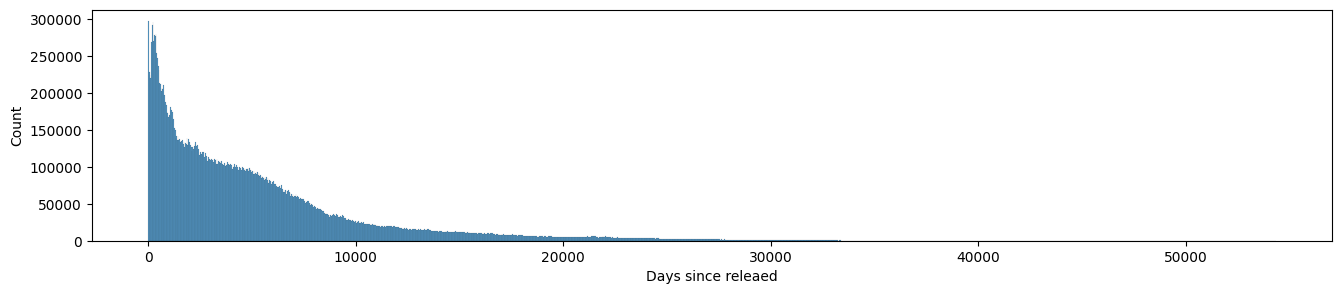

In [151]:
plt.figure(figsize = (16, 3))
sns.histplot(
    (df_ratings['ts'] - df_ratings['movieId'].map(df_movie['release_date'])).pipe(
        lambda x: x.where(x > 0, 0) // 1e9 // 3600 // 24
    ) # 개봉후 경과시점을 일단위로 환산합니다.
) 
plt.xlabel('Days since releaed')
plt.show()

- 역시 Movielens 영화 개봉 시점이 지날 수록 빈도가 떨어집니다. 즉 사용자의 관심에서 멀어 진다는 것을 알 수 있습니다.

- 이후에 개봉 경과 시점을 활용해보겠습니다.

#### 장르 (Genre)

In [152]:
# 영화 당 여러 개의 genre(장르)가 부여됩니다(movie:genre=1:N 관계). 이를 위한 처리를 합니다. (movieId, genre 리스트)인 튜플로 된 리스트를 만듭니다.
l_genre = [(k, [i['name'] for i in v['genres']]) for k, v in dic_movie_info_kr.items()]
# movieId, genres 리스트 컬럼으로된 DataFrame을 만듭니다
df_genre = pd.DataFrame(l_genre, columns=['movieId', 'genres']).set_index('movieId')
display(df_genre.head())
# movieId, genre로 된 DataFrame을 만듭니다.
df_genre = df_genre['genres'].explode().dropna()
df_genre.nunique(), df_genre.unique()

,genres
movieId,
1,"[애니메이션, 모험, 가족, 코미디]"
2,"[모험, 판타지, 가족]"
3,"[로맨스, 코미디]"
4,"[코미디, 드라마, 로맨스]"
5,"[코미디, 가족]"


(19,
 array(['애니메이션', '모험', '가족', '코미디', '판타지', '로맨스', '드라마', '액션', '범죄', '스릴러',
        '공포', '역사', 'SF', '미스터리', '전쟁', '음악', '다큐멘터리', '서부', 'TV 영화'],
       dtype=object))

- 장르의 특징

> 장르에 대한 신규 요소는 거의 등장하지 않은 고정성이 매우 강한 데이터입니다.
> 
> 하나의 영화는 여러 장르에 속할 수 있습니다.
> 
> 종류의 수가 많지 않은 편입니다. (19개)

In [153]:
df_genre = df_genre.reset_index().pivot_table(
    index = 'movieId', columns = 'genres', aggfunc = 'size', fill_value=0
)
cols_genre = df_genre.columns.tolist()
df_genre.head()

genres,SF,TV 영화,가족,공포,다큐멘터리,드라마,로맨스,모험,미스터리,범죄,서부,스릴러,애니메이션,액션,역사,음악,전쟁,코미디,판타지
movieId,,,,,,,,,,,,,,,,,,,
1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
2,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0
5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


#### 영화의 컬렉션 (Collection)

In [154]:
# 영화의 시리즈 정보를 정리합니다.(movie:series=1:1 관계)
l_collection = [
    (k,  v['belongs_to_collection']['name']) 
    for k, v in dic_movie_info_kr.items() if v['belongs_to_collection'] is not None
]
# 영화에 부여된 시리즈  정보를 pd.Series 형태로 만듭니다.
pd.DataFrame(l_collection, columns=['movieId', 'collection']).set_index('movieId').head()

,collection
movieId,
1,토이 스토리 시리즈
2,쥬만지 시리즈
3,Grumpy Old Men Collection
5,신부의 아버지 시리즈
6,Heat Collection


- 컬렉션의 특징

> 영화 1편이 최대 속하는 컬렉션은 하나. 1대 1 대응
>
> 3822 종류의 컬렉션이 존재 → 임베딩의 적용이 필요
>
> Movie 정보에 내장할 예정

→ 외부 인터페이스와 노출을 할 필요가 없으므로 Lookup 과정 없이 바로 Embedding에 전달할 수 있도록 미리 위치 인덱스로 매칭


In [155]:
s_collection = pd.DataFrame(l_collection, columns=['movieId', 'collection']).set_index('movieId')['collection']
# 영화의 컬렉션 정보를 1-base 인덱스로 변환하기 위한 매핑을 합니다.
s_col_map = pd.Series(np.arange(1, s_collection.nunique() + 1), index = s_collection.unique())
display(s_col_map.apply(lambda x: '→ {}'.format(x)))
# 영화의 컬렉션 정보를 1-base 인덱스로 변환합니다. 
display(
    pd.concat([
        s_collection.head().rename('before'), s_collection.head().map(s_col_map).rename('after')
    ], axis=1)
)
s_collection = s_collection.map(s_col_map)
del l_collection

토이 스토리 시리즈                          → 1
쥬만지 시리즈                             → 2
Grumpy Old Men Collection           → 3
신부의 아버지 시리즈                         → 4
Heat Collection                     → 5
                                  ...  
카우리스마키의 프롤레타리아 3부작               → 3818
드림 걸 시리즈                         → 3819
KKN di Desa Penari Collection    → 3820
공포의 묘지 (리부트) 시리즈                 → 3821
Angela Collection                → 3822
Length: 3822, dtype: object

,before,after
movieId,,
1,토이 스토리 시리즈,1
2,쥬만지 시리즈,2
3,Grumpy Old Men Collection,3
5,신부의 아버지 시리즈,4
6,Heat Collection,5


In [156]:
# 영화를 모델링하기 위한 정보를 만들어 냅니다.

# 우선 genre를 가변수화 합니다.
# 그리고, series 정보를 합칩니다.
df_movieinfo = pd.concat([
    df_genre, s_collection
], axis=1)

df_movieinfo['collection'] = df_movieinfo['collection'].fillna(0).astype(int)
# 영화마다 제목과 줄거리 Embedding을 ov_emb에 저장합니다.
df_movieinfo['ov_emb'] = df_movieinfo.index.to_series().map(movie_info_emb)
df_movieinfo['release_date'] = df_movie['release_date']
df_movieinfo['release_date'] = df_movieinfo['release_date'].fillna(df_movieinfo['release_date'].mean())
# avg_ov_emb: 등장하지 않은 영화의 줄거리 Embedding을 위해 Embedding이 있는 영화릐 평균을 구합니다.
avg_ov_emb = np.mean(
    np.vstack(
        df_movieinfo['ov_emb']
    ), axis=0
)
# df_movieinfo의 첫번째 행은 등장하지 않은 영화를 위한데이터 입니다. 평균 임베딩과 그외 다른 정보는 0으로 입력되게 합니다.
df_movieinfo = pd.concat([
    pd.DataFrame({'ov_emb': [avg_ov_emb], 'collection': [0], 'release_date': [df_movieinfo['release_date'].mean()]}, index=[0]),
    df_movieinfo
], axis=0).fillna(0)
df_movieinfo[cols_genre] = df_movieinfo[cols_genre].fillna(0).astype(int)
# 테스트 데이터에만 등장한 Series 데이터는 제외 시킵니다.
df_movieinfo.loc[
    ~df_movieinfo['collection'].isin(df_train['movieId'].map(df_movieinfo['collection']).dropna().astype(int).unique()),
    'collection'
] = 0
df_movieinfo

,ov_emb,collection,release_date,SF,TV 영화,가족,공포,다큐멘터리,드라마,로맨스,...,범죄,서부,스릴러,애니메이션,액션,역사,음악,전쟁,코미디,판타지
0,"[0.00029404839264264576, -0.021776316960201283...",0,817877247279650304.00000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"[-0.013183295726776123, -0.04171353206038475, ...",1,815011200000000000.00000,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,"[0.012337977066636086, -0.02982921712100506, -...",2,818985600000000000.00000,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,"[0.007722894661128521, -0.031341586261987686, ...",3,819590400000000000.00000,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,"[-0.01674286276102066, -0.04053124412894249, 0...",0,819590400000000000.00000,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262645,"[0.012292793951928616, -0.002778339898213744, ...",3054,60652800000000000.00000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
264380,"[0.0007624258287250996, 0.004107001703232527, ...",3189,297561600000000000.00000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
266382,"[-0.009176609106361866, -0.015016269870102406,...",3527,1271289600000000000.00000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
276555,"[-0.02276523970067501, -0.012596584856510162, ...",3627,1066608000000000000.00000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### 메타데이터 탑재

* 영화의 메타데이터를 학습 데이터에 그대로 결합을 한다면, 학습 데이터가 커져서 메모리에 담기 어려워 집니다. 
  
  Ex) 사이즈가 1536인 OpenAI 영화 줄거리 임베딩을 학습 데이터에 결합한다면, 3200만 × 1536 × 8 bytes(Float 타입 사이즈) = 약 390GB
  
  이를 모델에 탑재하여 데이터 사이즈의 폭증하는 문제를 해소합니다. 
  
* 영화에 대한 메타데이터를 모델에 포함하여 모델에는 movie id만 전달하기만 하면 되므로, 메타 데이터를 건건히 전달할 필요가 없어 추상화를 통한 네트워크 구성의 간소화를 가져갈 수 있습니다.

→ 영화 장르는  19개의 가변수 형태입니다. 이것을 영화수 x 19의 상수 행렬로 만들어 탑재시킵니다.

→ 영화 줄거리 임베딩은 1536개의 vector입니다. 이것을 영화수 x 1536의 상수 행렬로 만들어 탑재시킵니다.

→ 시리즈 정보는 1개의 정수입니다. 영화수만큼의 벡터로 탑재시킵니다.

→ 영화 개봉 시점(ns) 1개의 정수를 탑재 시키고, 입력 받은 시청 시점(ts)와 차를 구해 개봉 경과 시간을 구하고, 로그 변환과 정규화를 시킵니다.

IntegerLookup 레이로 movieId에 따른 위치인덱스를 가져와서, 해당 위치의 장르, 줄거리, 시리즈 정보를 탑재된 행렬에서 가져옵니다.

**tf.gather**: 위치인덱스에 해당하는 텐서를 가져옵니다.

In [157]:
# 입력 데이터에 메타데이터를 넣으면 2500천만건 × 메타데이터수 만큼(genre 19개, 시리즈 1개, 영화줄거리 임베딩: 1536개) 만큼의 데이터가
# 생기므로, 커다란 용량이 필요합니다. 
# 모델의 아이템의 메타데이터를 탑재시킵니다.

# 우선 장르부터 해봅니다.
# 장르의 가변수명을 가져옵니다. 사용합니다.

# 장르의 가변수를 상수 텐서로 만듭니다.
genres = tf.constant(
    df_movieinfo[cols_genre]
)
genres

<tf.Tensor: shape=(85247, 19), dtype=int64, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 1, 0],
       [0, 0, 1, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(85247, 19))>

In [158]:
# IntegerLookup을 통해 movieId에 대한 위치 인덱스를 가져옵니다.
lu_movie = tf.keras.layers.IntegerLookup(
    vocabulary=df_movieinfo.index[1:].values
)
# movieId가 1, 2 번인 영화의 위치 인덱스를 가져옵니다.
mid = lu_movie(tf.constant([1, 2, 206801]))
print(mid)
tf.gather(genres, mid) # tf.gather는 위치에 해당하는 장르정보를 genres에서 가져옵니다.

tf.Tensor([    1     2 85235], shape=(3,), dtype=int64)


<tf.Tensor: shape=(3, 19), dtype=int64, numpy=
array([[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])>

In [159]:
df_movieinfo.loc[[1, 2, 206801], cols_genre]

,SF,TV 영화,가족,공포,다큐멘터리,드라마,로맨스,모험,미스터리,범죄,서부,스릴러,애니메이션,액션,역사,음악,전쟁,코미디,판타지
1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
2,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
206801,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [160]:
# df_movieinfo['collection']
# 단일 데이터인 시리즈를 tf.constant로 만듭니다.
collection = tf.constant(df_movieinfo['collection'])
# 영화 줄거리 Embedding을 tf.constant로 만듭니다. df_movieinfo['ov_emb']
ov_emb = tf.constant(df_movieinfo['ov_emb'].tolist())
# 영화 개봉 시점을 저장합니다.
release_date = tf.constant(df_movieinfo['release_date'], dtype=tf.int64)

mid = lu_movie(tf.constant([2, 3, 206801]))
# 영화에 대한 데이터가 저장된 위치 인덱스를 가져옵니다.
tf.gather(ov_emb, mid)# tf.gather를 사용해서 ov_emb에 해당 영화릐 줄거리 임베딩을 가져옵니다.

<tf.Tensor: shape=(3, 1536), dtype=float64, numpy=
array([[ 0.01233798, -0.02982922, -0.0102611 , ..., -0.03060805,
        -0.00180267, -0.02200197],
       [ 0.00772289, -0.03134159,  0.00669053, ..., -0.01048249,
        -0.00704127, -0.01465166],
       [ 0.00722172,  0.00634434, -0.0208472 , ..., -0.0220916 ,
        -0.00236646, -0.0427011 ]], shape=(3, 1536))>

In [161]:
df_movieinfo.loc[[2, 3, 206801], 'ov_emb']

2         [0.012337977066636086, -0.02982921712100506, -...
3         [0.007722894661128521, -0.031341586261987686, ...
206801    [0.0072217159904539585, 0.00634434400126338, -...
Name: ov_emb, dtype: object

In [162]:
tf.gather(collection, mid)

<tf.Tensor: shape=(3,), dtype=int64, numpy=array([   2,    3, 2890])>

In [163]:
df_movieinfo.loc[[2, 3, 60728], 'collection']

2        2
3        3
60728    0
Name: collection, dtype: int64

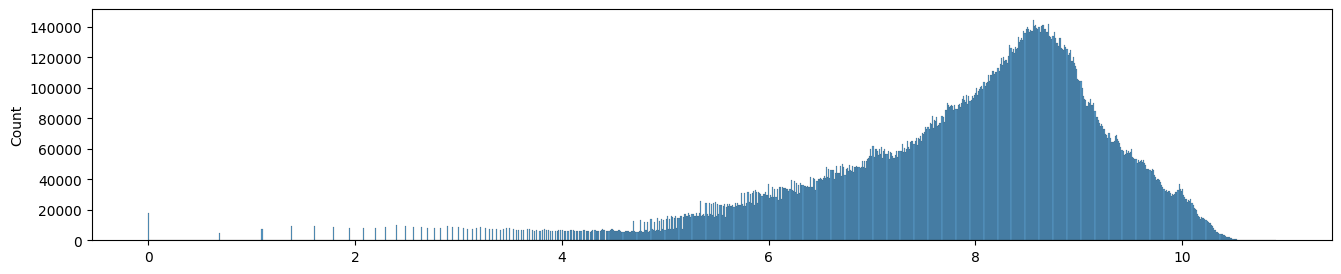

In [164]:
# 로그 변환을 통해 데이터의 편차를 줄입니다.
plt.figure(figsize = (16, 3))
sns.histplot(
    np.log((df_ratings['ts'] - df_ratings['movieId'].map(df_movie['release_date'])).pipe(lambda x: x.where(x > 0, 0) // 1e9 // 3600 // 24) + 1)
)
plt.show()

In [165]:
# 평가 시점과 개봉 시점의 차이의 log를 구합니다.
(tf.minimum(
    tf.math.log(
        tf.maximum(
            tf.cast(tf.constant(df_ratings['ts'].iloc[:3]) - tf.gather(release_date, mid), tf.float64) // 1e9 // 3600 // 24, 1
        )
    ), 10
) - 5) / 5

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([ 0.45406258,  0.45308594, -1.        ])>

In [166]:
del collection, ov_emb, release_date, genres

### MovieInfoModel

장르, 시리즈, 줄거리 임베딩과 개봉 시점을 포함한 영화 정보를 포함한 영화 모델입니다.

```mermaid

flowchart LR
    subgraph in[Inputs]
        mId(movieId)
        ts(ts)
    end
    subgraph mim["<div style='white-space:nowrap;'>MovieInfoModel(movieinfo, movie_ids, emb_config, output_size, hidden_units)</div>"]
        subgraph movie["<div style='white-space:nowrap;'>Movie Block, M: emb_config['movie'] + emb_config['collection'] + 19 + 1536 + 1</div>"]
            direction TB
    
            subgraph m_m["movie_model:EmbModel"]
                sz1["<div style='white-space:nowrap;'>ids: movie_ids<br/>size:emb_config['movie']</div>"]
            end
            subgraph m_info["movie_info"]
                subgraph ILL[IntegerLookup]
                    voc["vocabulary: id"]
                end
                subgraph genre["gather"]
                    const_genre[genres]
                end
                subgraph ov_emb["gather"]
                    const_ov_emb[ov_emb]
                end 
                subgraph collection["collection"]
                    direction TB
                    const_collection["gather(collection)"]
                    Emb["<div style='white-space:nowrap;'>Embedding<br/>collection수xemb_config['collection']</div>"]
                    const_collection-->Emb
                end
                subgraph release_date["gather"]
                    const_release_date[release_date]
                end
                
                ILL-->|N|genre
                ILL-->|N|ov_emb
                ILL-->|N|collection
                ILL-->|N|release_date
                
            end
            subgraph rsed["개봉경과시점"]
                direction TB
                op_sub["개봉경과시점"]
                ed["expand_dims(axis=-1)"]
            end
            subgraph cc[Concatenate]
                p["axis=-1<br/>"]
            end
        end
    
        subgraph hls[<b>Hidden Layers</b>]
            direction TB
            subgraph h1["H_1:Dense"]
                us1["unit_size: hidden_units[1]<br/>activation: ReLU"]
            end
            hdot["..."]
            subgraph hn["H_n:Dense"]
                usn[unit_size: output_size]
            end
            h1-->|"Nxhidden_units[1]"|hdot
            hdot-->|"Nxhidden_units[n-1]"|hn
        end
    end
    mout((Movie<br/>embedding))
    mId-->|N|m_m
    mId-->|N|ILL
    m_m-->|"Nxemb_config['movie']"|cc
    genre-->|Nx19|cc
    ov_emb-->|Nx1536|cc
    collection-->|"Nxemb_config['collection']"|cc
    ts-->|N|rsed
    release_date-->|N|rsed
    op_sub-->|N|ed
    rsed-->|Nx1|cc
    cc-->|NxM|hls
    hls-->|Nxoutput_size|mout

    classDef layer fill:#E3F2FD,stroke:#1E88E5,stroke-width:1px,color:#0D47A1
    classDef trainable fill:#E8F5E9,stroke:#2E7D32,stroke-width:1px,color:#1B5E20
    classDef nontrainable fill:#FCE4EC,stroke:#C2185B,stroke-width:1px,color:#880E4F

    class us1 trainable
    class usn trainable
    class h1 layer
    class hdot layer
    class hn layer
    class voc nontrainable
    class const_genre nontrainable
    class const_ov_emb nontrainable
    class const_collection nontrainable
    class Emb layer
    class const_release_date nontrainable
    class cc layer
```

In [167]:
class MovieInfoModel(tf.keras.Model):
    """
    영화 메타데이터 기반 모델
    
    영화의 다양한 정보를 활용하여 영화 벡터를 생성합니다:
    - 장르 (Genre)
    - 컬렉션 (Collection)  
    - 줄거리 임베딩 (OpenAI API로 생성된 텍스트 임베딩)
    - 개봉일 (시간 경과 정보)
    """
    def __init__(self, movieinfo, movie_ids, emb_config, output_size, hidden_units = [], l2=0):
        """
        Args:
            movieinfo (dict): 영화 메타데이터
                - ids: 영화 ID 목록
                - genre: 장르 원-핫 벡터
                - collection: 컬렉션 ID
                - ov_emb: OpenAI 임베딩
                - release_date: 개봉일 (timestamp)
            movie_ids (list): 영화 ID 목록
            emb_config (dict): 임베딩 설정 {'movie': 크기, 'collection': 크기}
            output_size (int): 출력 벡터 크기
            hidden_units (list): 히든 레이어 크기들
            l2 (float): L2 정규화 계수
        """
        super().__init__()
        self.ids = movieinfo['ids']
        # 영화 ID를 인덱스로 변환
        self.lu_movie = tf.keras.layers.IntegerLookup(
            vocabulary=movieinfo['ids'][1:]
        )
        # 영화 별 장르 정보를 담고 저장공간생성
        self.genres = tf.constant(movieinfo['genre'])
        # 영화의 컬렉션 정보를 지니고 있는 저장공간 생성
        self.collection = tf.constant(movieinfo['collection'])
        # 영화의 제목 + 줄거리의 OpenAI에서 구한 Embedding 정보 저장공간 생성
        self.ov_emb = tf.constant(movieinfo['ov_emb'])
        # 개봉일 정보
        self.release_date = tf.constant(movieinfo['release_date'], dtype=tf.int64)
        # 영화 기본 임베딩
        self.movie_model = EmbModel(movie_ids, emb_config['movie'])
        
        # L2 정규화 설정
        if l2 > 0:
            reg = tf.keras.regularizers.L2(l2)
        else:
            reg = None
            
        # 컬렉션 임베딩 레이어
        self.emb_collection = tf.keras.layers.Embedding(
            np.max(movieinfo['collection']) + 1, 
            emb_config['collection'], 
            embeddings_regularizer = reg
        )

        # 결합 레이어
        self.cc = tf.keras.layers.Concatenate(axis = -1)
        
        # 밀도 은닉층
        self.hidden_layers = [
            tf.keras.layers.Dense(
                i, activation='relu', 
                kernel_initializer=tf.keras.initializers.HeNormal(), 
                kernel_regularizer=reg
            ) for i in hidden_units
        ]
        
        # 출력 레이어: Dense(rank)
        if output_size > 0:
            self.o = tf.keras.layers.Dense(
                output_size, kernel_initializer = tf.keras.initializers.GlorotNormal(), kernel_regularizer=reg
            )
        else:
            self.o = None
        self.output_size = output_size

    def get_movieinfo(self):
        """저장된 영화 메타데이터 반환"""
        return {
            'ids': self.ids,
            'genre': self.genres.numpy(),
            'collection': self.collection.numpy(),
            'ov_emb': self.ov_emb.numpy(),
            'release_date': self.release_date.numpy(),
        }
        
    def build(self):
        """모델 초기화"""
        movie_model_shape = (None, self.movie_model.output_size)
        self.movie_model.build()
        self.emb_collection.build((None, ))
        # Concatenate 후 shape 계산: [기본임베딩, 장르, 컬렉션, 텍스트임베딩, 시간]
        shape_ = self.cc.compute_output_shape(
            [
                movie_model_shape, (None, self.genres.shape[-1]), 
                self.emb_collection.compute_output_shape((None, )), 
                (None, self.ov_emb.shape[-1]),(None, 1)
            ]
        )
        # 히든 레이어들 빌드
        for i in self.hidden_layers:
            i.build(shape_)
            shape_ = i.compute_output_shape(shape_)
        # 출력 레이어 빌드
        if self.o is not None:
            self.o.build(shape_)
        else:
            self.output_size = shape_[-1]

    def call(self, x, ts, training=False):
        """
        영화 벡터 생성
        
        Args:
            x: 영화 ID
            ts: 현재 시간 (timestamp)
            training: 학습 모드 여부
            
        Returns:
            영화 특성 벡터
        """
        # 기본 영화 임베딩
        x_movie = self.movie_model(x, training=training)
        
        # 인덱스로 변환
        x = self.lu_movie(x)
        # 장르 여부를 가져옵니다.
        x_genre = tf.gather(self.genres, x)
        # 컬렉션 번호 가져옵니다.
        x_collection = tf.gather(self.collection, x)
        # 컬렉션 임베딩을 가져옵니다.
        x_collection = self.emb_collection(x_collection)
        # OpenAI API를 얻은 영화 줄거리의 Embedding 정보를 가져 옵니다.
        x_ov_emb =  tf.gather(self.ov_emb, x)
        # 개봉일 가져오기
        x_ts = tf.gather(self.release_date, x)
        # 개봉 경과일의 Log를 -1 ~ 1로 스케일로 만듭니다.
        x_ts = tf.cast(
            (tf.minimum(
                tf.math.log(
                    tf.maximum(
                        tf.cast(ts  - x_ts, tf.float64) // 1e9 // 3600 // 24, 1  # 일 단위 경과
                    )
                ), 10  # 최대 log(10)
            ) - 5) / 5,  # -1 ~ 1 범위로 정규화
            tf.float32
        )
        # x_movie, x_genre, x_collection, x_ov_emb를 결합하여 하나의 텐서로 만듭니다.
        x =  self.cc([
            x_movie, x_genre, x_collection, x_ov_emb, tf.expand_dims(x_ts, axis = -1)
        ])
        # 히든 레이어들 통과
        for i in self.hidden_layers:
            x = i(x)
        # 출력
        if self.o is not None:
            return self.o(x)
        else:
            return x

### UserHistModel_ts

- 사용자의 시청 이력 모델에 평가 시점을 추가한 모델 입니다.

**모델 구조**

```mermaid
%%{init: {
  "flowchart": {
    "nodeSpacing": 30
  }
}}%%
flowchart LR
    subgraph I[Inputs]
        uId(userId)
        pR(prev_rating)
        mId(prev_movieId)
        pts(prev_ts)
    end
    subgraph mm["<div style='white-space:nowrap;'>UserHistModel_ts(user_ids, user_emb_size, movie_model, output_size, hidden_units)</div>"]
        subgraph u_m["user_model:EmbModel"]
            sz1["ids: user_ids, size:user_emb_size"]
        end
        m_m["movie_model:MovieInfoModel"]
        subgraph cc[Concatenate]
            p[<div style='white-space:nowrap;'>axis=-1<br/>M=rank+user_emb_size+1</div>]
        end
        ed["expand_dims(axis=-1)"]

        subgraph hls[Hidden Layers]
            direction TB
            subgraph h1["H_1:Dense"]
                us1["unit_size: hidden_units[1]"]
            end
            hdot["..."]
            subgraph hn["H_n:Dense"]
                usn[unit_size: output_size]
            end
        end
    end
    
    output(User embedding)
    uId-->|N|u_m
    mId-->|N|m_m
    pts-->|N|m_m
    u_m-->|Nxuser_emb_size|cc
    m_m-->|Nxrank|cc
    pR-->|N|ed
    ed-->|Nx1|cc
    style m_m stroke-dasharray: 5

    cc-->|"NxM"|hls
    h1-->|"Nxhidden_units[1]"|hdot
    hdot-->|"Nx..."|hn
    hls-->|Nxoutput_size|output

    classDef layer fill:#E3F2FD,stroke:#1E88E5,stroke-width:1px,color:#0D47A1
    classDef trainable fill:#E8F5E9,stroke:#2E7D32,stroke-width:1px,color:#1B5E20
    classDef nontrainable fill:#FCE4EC,stroke:#C2185B,stroke-width:1px,color:#880E4F

    class cc layer
    class us1 trainable
    class usn trainable
    class h1 layer
    class hdot layer
    class hn layer
```

In [168]:
class UserHistModel_ts(UserHistModel):
    def call(self, x, prev_movieId, prev_rating, prev_ts, training=False):
        x = self.cc([
             self.user_model(x), # 사용자 벡터를 가져옵니다. N×rank
             self.movie_model(prev_movieId, prev_ts), # 이전 시청 영화 벡터를 가져옵니다. N×rank
             tf.expand_dims(prev_rating, axis=-1) # 이전 평점. N×1
        ]) # N×(2×rank + 1)
        
        for i in self.hidden_layers:
            x = i(x)
        if self.o is not None:
            return  self.o(x) # 출력층. N×output_size
        else:
            return self.x

```mermaid
%%{init: {
  "flowchart": {
    "nodeSpacing": 35
  }
}}%%
flowchart LR
    subgraph Ips[Inputs]
        direction LR
        uId(userId)
        mId(movieId)
        pR(prev_rating)
        pmId(prev_movieId)
        pts(prev_ts)
        ts(ts)
    end
    subgraph mm["<div style='white-space:nowrap;'>MFModel2_2( user_ids, user_emb_size, user_hidden_units, movieinfo, movie_ids, movie_emb_config, movie_hidden_units, rank)</div>"]
        direction LR
        subgraph u_m["user_model:UserHistModel"]
            sz1["<div style='text-align: left;'> user_ids, user_emb_size, user_hidden_units, rank</div>"]
        end
        subgraph m_m["movie_model:MovieInfoModel"]
            sz2["<div style='white-space:nowrap;'> movieinfo, movie_ids, movie_emb_config,<br/> movie_hidden_units, rank</div>"]
        end
        Rw["Dot(axis=-1)"]
    end
    
    output((Rating))
    uId-->|N|u_m
    mId-->|N|m_m
    pR-->|N|u_m
    pmId-->|N|u_m
    pts-->|N|u_m
    u_m-->|"<div style='color:red'>prev_movieId:N</div>"|m_m
    u_m-->|"<div style='color:red'>prev_ts:N</div>"|m_m
    m_m-->|"<div style='color:red'>Nxrank</div>"|u_m
    ts-->|N|m_m
    u_m-->|Nxrank|Rw
    m_m-->|Nxrank|Rw
    
    Rw-->|Nx1|output
    

    classDef layer fill:#E3F2FD,stroke:#1E88E5,stroke-width:1px,color:#0D47A1
    classDef trainable fill:#E8F5E9,stroke:#2E7D32,stroke-width:1px,color:#1B5E20
    classDef nontrainable fill:#FCE4EC,stroke:#C2185B,stroke-width:1px,color:#880E4F

    class Rw layer
```

### MFModel2_2

**모델 구조**

```mermaid
%%{init: {
  "flowchart": {
    "nodeSpacing": 35
  }
}}%%
flowchart LR
    subgraph Ips[Inputs]
        direction LR
        uId(userId)
        mId(movieId)
        ts(ts)
        pR(prev_rating)
        pmId(prev_movieId)
        prev_ts(prev_ts)
    end
    subgraph mm["<div style='white-space:nowrap;'>MFModel2_2(user_ids, user_emb_size, user_hidden_units, movie_ids, rank)</div>"]
        direction LR
        subgraph u_m["user_model:UserHistModel_ts"]
            sz1["<div style='text-align: left;'>ids: user_ids, user_emb_size:user_emb_size, hidden_units:user_hidden_units, output_size:rank</div>"]
        end
        subgraph m_m["movie_model:EmbModel"]
            sz2["<div style='white-space:nowrap;'>ids: movie_ids, size:rank</div>"]
        end
        Rw((Row-wise<br/>dot product))
    end
    
    output((Rating))
    uId-->|N|u_m
    mId-->|N|m_m
    ts-->|N|m_m
    pR-->|N|u_m
    pmId-->|N|u_m
    prev_ts-->|N|u_m
    u_m-->|"<div style='color:red'>prev_movieId:N</div>"|m_m
    u_m-->|"<div style='color:red'>prev_ts:N</div>"|m_m
    m_m-->|"<div style='color:red'>Nxrank</div>"|u_m
    u_m-->|Nxrank|Rw
    m_m-->|Nxrank|Rw
    Rw-->|Nx1|output

    classDef layer fill:#E3F2FD,stroke:#1E88E5,stroke-width:1px,color:#0D47A1
    classDef trainable fill:#E8F5E9,stroke:#2E7D32,stroke-width:1px,color:#1B5E20
    classDef nontrainable fill:#FCE4EC,stroke:#C2185B,stroke-width:1px,color:#880E4F

    class Rw layer
```

In [169]:
class MFModel2_2(tf.keras.Model):
    """
    Matrix Factorization 2-2 모델
    
    MFModel2에서 UserHistModel이 prev_movieId(이전 시청 영화 ID), prev_rating(이전 평점), 
    prev_ts(이전 본 시점)을 받을 수 있도록 업그레이드한 모델입니다.
    
    다음 모든 정보를 활용합니다:
    - 사용자 시청 이력 (UserHistModel_ts)
    - 영화 메타데이터: 장르, 컬렉션, 줄거리 임베딩 (MovieInfoModel)
    - 시간 정보: 시청 시점, 개봉 경과
    
    예측식: rating = user_hist_vector(with time) · movie_info_vector(with time)
    """
    def __init__(self, 
                 user_ids, user_emb_size, user_hidden_units, 
                 movieinfo, movie_ids, movie_emb_config, movie_hidden_units,
                 rank
        ):
        """
        Args:
            user_ids (list): 사용자 ID 목록
            user_emb_size (int): 사용자 임베딩 크기
            user_hidden_units (list): 사용자 모델 히든 레이어 크기들
            movieinfo (dict): 영화 메타데이터
            movie_ids (list): 영화 ID 목록
            movie_emb_config (dict): 영화 임베딩 설정
            movie_hidden_units (list): 영화 모델 히든 레이어 크기들
            rank (int): 잠재 벡터 차원 수
        """
        super().__init__()
        self.user_ids = user_ids
        self.user_emb_size = user_emb_size
        self.user_hidden_units = user_hidden_units
        self.movie_ids = movie_ids
        self.movie_emb_config = movie_emb_config
        self.movie_hidden_units = movie_hidden_units
        self.rank = rank
        self.is_built = False
        
        # 영화 모델 (메타데이터 포함)
        self.movie_model = MovieInfoModel(movieinfo, movie_ids, movie_emb_config, rank, movie_hidden_units)
        # 사용자 모델 (시청 이력 + 시간 정보)
        self.user_model = UserHistModel_ts(user_ids, user_emb_size, self.movie_model, rank, user_hidden_units)
        # Row-wise dot Product를 하도록 설정합니다.
        self.dot = tf.keras.layers.Dot(axes=-1)

    def build(self):
        """모델 초기화"""
        if self.is_built:
            return
        self.user_model.build()
        self.movie_model.build()
        self.is_built = True
        
    def call(self, x, training=False):
        """
        평점 예측 (모든 정보 활용)
        
        Args:
            x (dict):
                - userId: 사용자 ID
                - prev_movieId: 이전 본 영화 ID
                - prev_rating: 이전 평점
                - prev_ts: 이전 시청 시간
                - movieId: 예측할 영화 ID
                - ts: 현재 시간
            training: 학습 모드 여부
            
        Returns:
            예측 평점
        """
        # 사용자 벡터 생성 (UserHistModel)에 userId, prev_movieId, prev_rating을 입력하여
        # 사용자 벡터를 생성합니다.
        x_user = self.user_model(
            x['userId'], # N
            x['prev_movieId'], # N
            x['prev_rating'], # N
            x['prev_ts'], # N
            training=training
        ) # N×32
        x_movie = self.movie_model(
            x['movieId'], # N
            x['ts'], # N
            training=training
        ) # N×32
        return self.dot([x_user, x_movie])

    def get_model_data(self):
        """모델 가중치와 설정을 딕셔너리로 반환 (저장용)"""
        return {
            'user_ids': self.user_ids,
            'user_emb_size': self.user_emb_size, 
            'user_hidden_units': list(self.user_hidden_units),
            'movieinfo': self.movie_model.get_movieinfo(), 
            'movie_ids': self.movie_ids,
            'movie_emb_config': dict(self.movie_emb_config),
            'movie_hidden_units': list(self.movie_hidden_units),
            'user_model': self.user_model.get_weights(),
            'movie_model': self.movie_model.get_weights(),
            'rank': self.rank
        }

    def from_model_data(model_data):
        """저장된 모델 데이터로부터 모델 복원"""
        model = MFModel2_2(
            model_data['user_ids'],  model_data['user_emb_size'], model_data['user_hidden_units'],
            model_data['movieinfo'], model_data['movie_ids'], model_data['movie_emb_config'], model_data['movie_hidden_units'],
            model_data['rank']
        )
        model.build()
        model.user_model.set_weights(model_data['user_model'])
        model.movie_model.set_weights(model_data['movie_model'])
        return model

    def predict_by_userid(self, x):
        """
        한 사용자에 대한 여러 영화 평점 예측
        
        call()에서의 연산은 (사용자1, 아이템1), (사용자2, 아이템2), ... 의 쌍별 예측입니다.
        실제 모델은 사용자 단위로 다수의 아이템에 대한 예측을 하게 됩니다.
        이러한 상황을 고려한 더욱 최적화한 루틴으로,
        한명의 사용자에게 여러 개의 아이템의 평점을 예측합니다.
        
        Args:
            x (dict):
                - userId: 사용자 ID
                - prev_movieId: 이전 본 영화 ID
                - prev_rating: 이전 평점
                - prev_ts: 이전 시청 시간
                - movieIds: [영화 ID 리스트]
                - ts: 현재 시간
        """
        
        x_user = self.user_model(
            x['userId'], # N
            prev_movieId=x['prev_movieId'], # N
            prev_rating=x['prev_rating'], # N
            prev_ts=x['prev_ts'], # N
            training=False
        )
        # item id 별로 user id의 임베딩을 가져오는 작업과, item id 별로 반복되는 user_emb를 만들 필요가 없고 단일 벡터와 
        # item id 행렬의 곱의 연산이 되므로 계산량이 줄어 들게 됩니다.
        x_movie = self.movie_model(
            x['movieIds'], # N
            x['ts'], # N
            training=False
        )
        return tf.squeeze(
            tf.matmul(x_movie, x_user, transpose_b=True)
        )
        
    def get_user_vec(self, user_id, **argv):
        """특정 사용자의 임베딩 벡터 반환 (이력 + 시간 포함)"""
        return tf.squeeze(
            self.user_model(
                tf.constant([user_id]), prev_movieId=tf.constant([argv['prev_movieId']]), 
                prev_rating=tf.constant([argv['prev_rating']]), prev_ts=tf.constant([argv['prev_ts']])
            )
        )

    def get_item_vecs(self, item_ids, **argv):
        """여러 영화의 임베딩 벡터들 반환 (메타데이터 + 시간 포함)"""
        return self.movie_model(tf.constant(item_ids), ts=tf.constant([argv['ts']] * len(item_ids)))

- mf2_model의 동작을 확인하고, mean_model과 앙상블 모델을 구성하여 최종 동작을 합니다.

In [170]:
tf.keras.backend.clear_session()
cols_genre = [i for i in df_movieinfo.columns if i.startswith('genre')]
movieinfo = {
    'ids': df_movieinfo.index.values,
    'genre': df_movieinfo[cols_genre].values,
    'collection': df_movieinfo['collection'].values,
    'ov_emb': np.vstack(df_movieinfo['ov_emb'].tolist()),
    'release_date': df_movieinfo['release_date'].values
}
mf_model2_2 = MFModel2_2(
    s_userCnt.loc[s_userCnt >= 140].index.values, 32, [64], 
    movieinfo, s_movieCnt.loc[s_movieCnt >= 100].index.values, {'movie': 32, 'collection': 8}, [64],
    rank = 32
)
ts_mean = df_ratings['ts'].mean().astype('int64')
mf_model2_2({'userId': tf.constant([1, 2]), 'movieId': tf.constant([1, 5]), 'ts': tf.constant([ts_mean, ts_mean], dtype = tf.int64),
          'prev_movieId': tf.constant([0, 1]), 'prev_rating': tf.constant([1.0, 3.5]), 'prev_ts': tf.constant([ts_mean, ts_mean], dtype = tf.int64)})

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[-0.03336379],
       [-0.20676833]], dtype=float32)>

In [171]:
del cols_genre, movieinfo, mf_model2_2

## mf2_2 학습과 검증

**모델 구성**

```mermaid
%%{init: {
  "flowchart": {
    "nodeSpacing": 40
  }
}}%%
flowchart LR
    subgraph Ips[Inputs]
        direction LR
        uId(userId)
        mId(movieId)
        ts(ts)
        pR(prev_rating)
        pmId(prev_movieId)
        pts(prev_ts)
    end
    subgraph AM["a_model:AdditiveModel"]
        direction LR
        subgraph mm["mean_model:MeanModel"]
            direction LR
            param1[<div style='line-height:1.1;text-align: left;'><div style='white-space:nowrap;'>user_ids: 출현 빈도 1회 넘는 userId</div><br/><div style='white-space:nowrap;'>movie_ids: 출현 빈도 1회 넘는 movieId</div></div>]
        end
        subgraph mf["mf_model2_2:MFModel2_2"]
            direction LR
            param3["<div style='line-height:1.1;text-align: left;'><div style='white-space:nowrap;'>user_ids: 출현 빈도 140회 넘는 userId</div><br/><div style='white-space:nowrap;'>user_emb_size: 32</div><br/><div style='white-space:nowrap;'>user_hidden_units: [64]</div><br/><div style='white-space:nowrap;'>movieinfo: movieinfo</div><br/><div style='white-space:nowrap;'>movie_ids: 출현 빈도 100회 넘는 movieId</div><br/><div style='white-space:nowrap;'>movie_emb_config:{'movie':32, 'collection': 8}</div><br/><div style='white-space:nowrap;'>movie_hidden_units: [64]</div><br/><div style='white-space:nowrap;'>rank: 32</div></div>"]
        end
    end
    output((Rating))

    uId-->|N|AM
    mId-->|N|AM
    ts-->|N|AM
    pmId-->|N|AM
    pR-->|N|AM
    pts-->|N|AM
    AM-->|N|output
```

In [172]:
# mf2_2.pkl 이 없으면 학습을 하고, 학습 산출물를 mf2_2.pkl에 저장합니다.
# mf2_2.pkl 이 있으면 학습 산출물을 불러오고, 결과를 출력하고, 기존의 모델을 불러옵니다.
model_filename = os.path.join(model_path, 'mf2_2.pkl')

# 이미 학습된 내용을 저장한 파일을 다운로드 받습니다.
"""
if not os.path.exists(model_filename):
    o = gdown.download("https://drive.google.com/uc?id=1H3UY07qkmcgRTpred-3ZyydQT_zghfv2", quiet=False)
    os.rename(o, model_filename)
"""

if not os.path.isfile(model_filename):
    tf.keras.backend.clear_session()
    mean_model = MeanModel(
        rating_train_mean, 
        s_userCnt.loc[s_userCnt > 1].index.values, 
        s_movieCnt.loc[s_movieCnt > 1].index.values
    )
    cols_genre = df_movieinfo.columns[-19:].tolist()
    movieinfo = {
        'ids': df_movieinfo.index.values,
        'genre': df_movieinfo[cols_genre].values,
        'collection': df_movieinfo['collection'].values,
        'ov_emb': df_movieinfo['ov_emb'].tolist(),
        'release_date': df_movieinfo['release_date'].values
    }
    mf_model2_2 = MFModel2_2(
        s_userCnt.loc[s_userCnt >= 140].index.values, 32, [64], 
        movieinfo, s_movieCnt.loc[s_movieCnt >= 100].index.values, {'movie': 32, 'collection': 8}, [64],
        rank = 32
    )
    # mf_model과 mean_model을 AdditiveModel로 결합합니다.
    a_model = AdditiveModel([mean_model, mf_model2_2])
    a_model.compile(
        optimizer=tf.keras.optimizers.Adam(3e-5),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.MeanSquaredError()]
    )
    user_bins = [0, 1, 140, 500, 1000, np.inf]
    movie_bins = [0, 1, 100, 1000, 5000, 10000, np.inf]
    df_result_mf2_2 = train_rcmd_model(a_model, 10, user_bins, movie_bins)
    with open(model_filename, 'wb') as f:
        pickle.dump({
            'mean_model': mean_model.get_model_data(),
            'mf_model2': mf_model2_2.get_model_data(),
            'result': df_result_mf2_2
        }, f)
else:
    with open(model_filename, 'rb') as f:
        mf2_2 = pickle.load(f)
    # 학습 결과를 출력합니다.
    df_result_mf2_2 = mf2_2['result']
    display(df_result_mf2_2)
    # 모델을  만듭니다.
    tf.keras.backend.clear_session()
    mean_model = MeanModel.from_model_data(mf2_2['mean_model'])
    mf_model2_2 = MFModel2_2.from_model_data(mf2_2['mf_model2'])
    a_model = AdditiveModel([mean_model, mf_model2_2])
    del mf2_2

userCnt                                              \
     train    test [0.0, 1.0) [1.0, 140.0) [140.0, 500.0) [500.0, 1000.0)   
1  0.72211 0.75827    0.78639      0.75022        0.69583         0.66250   
2  0.70800 0.75555    0.78030      0.74463        0.70059         0.67068   
3  0.68585 0.75236    0.77834      0.74299        0.69229         0.66031   
4  0.67306 0.74864    0.77820      0.73874        0.67903         0.64655   
5  0.66667 0.74839    0.77893      0.73993        0.67693         0.64430   
6  0.65885 0.74372    0.77563      0.73142        0.66829         0.63839   
7  0.65195 0.74327    0.77470      0.72949        0.66630         0.64083   
8  0.64403 0.74342    0.77576      0.72800        0.66542         0.63992   
9  0.63809 0.74324    0.77603      0.72725        0.66467         0.63913   
10 0.63184 0.74566    0.78043      0.73148        0.66385         0.63465   

                   movieCnt                                                \
   [1000.0, inf) [0.0, 1.0) [1.0, 100.0) [100.0, 1000.0) [1000.0, 5000.0)   
1        0.66855    0.95817      0.90728         0.78051          0.76497   
2        0.67915    1.05184      0.91093         0.77261          0.75643   
3        0.67497    1.10152      0.90466         0.76753          0.74958   
4        0.65983    1.05513      0.89315         0.76973          0.74804   
5        0.65426    1.03858      0.89080         0.76967          0.74891   
6        0.64607    1.03522      0.88256         0.76186          0.74401   
7        0.64973    1.06913      0.87750         0.75768          0.74224   
8        0.64564    1.07524      0.87413         0.75697          0.74301   
9        0.64331    1.08656      0.86976         0.75515          0.74243   
10       0.63706    1.06793      0.87087         0.76371          0.74931   

                                     
   [5000.0, 10000.0) [10000.0, inf)  
1            0.72566        0.71157  
2            0.71796        0.70441  
3            0.71303        0.69965  
4            0.71191        0.69785  
5            0.71314        0.69846  
6            0.70877        0.69529  
7            0.70692        0.69460  
8            0.70758        0.69463  
9            0.70682        0.69501  
10           0.71058        0.69524

In [173]:
import scann

scann_index = scann.scann_ops.builder(
    np.vstack([
        a_model.get_item_vecs(df_movie.index[i: i + 1024], ts = df_test['ts'].mean().astype('int64')).numpy()
        for i in range(0, len(df_movie.index), 1024)
    ]), 1000, 'dot_product'
).tree(
    num_leaves=1000, num_leaves_to_search=100, training_sample_size=100000
).score_ah(
    2, anisotropic_quantization_threshold=0.2
).reorder(1000).build()

I0000 00:00:1765882630.520088      60 partitioner_factory_base.cc:58] Size of sampled dataset for training partition: 87561
I0000 00:00:1765882630.680202      60 kmeans_tree_partitioner_utils.h:90] PartitionerFactory ran in 160.074578ms.


In [174]:
df_prev = df_ratings.query('userId == 171795').sort_values('date', ascending = False).iloc[[0]][['prev_movieId', 'prev_rating', 'prev_ts']]
df_prev

,prev_movieId,prev_rating,prev_ts
27374526,222477,3.50000,1609626059000000000


In [175]:
labels, sims = scann_index.search(
    a_model.get_user_vec(171795, prev_movieId=222477, prev_rating=3.5, prev_ts=1609626059000000000)
)
df_movie.iloc[labels[:10].numpy(), :2]

,title,genres
movieId,,
171011,Planet Earth II (2016),Documentary
159817,Planet Earth (2006),Documentary
170705,Band of Brothers (2001),Action|Drama|War
179135,Blue Planet II (2017),Documentary
182723,Cosmos: A Spacetime Odissey,(no genres listed)
171495,Cosmos,(no genres listed)
142115,The Blue Planet (2001),Documentary
174703,I Am So Proud of You (2008),Action|Animation|Sci-Fi|Thriller
100044,Human Planet (2011),Documentary


In [176]:
a_model.summary()

Model: "additive_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mean_model (MeanModel)          │ ?                      │       258,636 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mf_model2_2 (MFModel2_2)        │ ?                      │     2,372,328 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,630,964 (10.04 MB)

 Trainable params: 2,630,964 (10.04 MB)

 Non-trainable params: 0 (0.00 B)

In [177]:
# 평가 데이터의 예측 결과를 뽑아냅니다.
prds = predict(a_model, ds_test, 1024)
df_prd = pd.DataFrame({'rating': df_test['rating'], 'prds': prds})
# 학습셋의 사용자 평점수 구간별 테스트셋의 성능을 구합니다.
s_type_dic = {
    i: str(i) for i in s_user_type.cat.categories
}
s_type_dic[s_user_type.cat.categories[1]] = '[1.0, 기준 빈도)'
s_type_dic[s_user_type.cat.categories[2]] = '[기준 빈도, 500)'
s_mf_user = df_prd.groupby(
    s_user_type.map(s_type_dic), observed=True
).apply(lambda x: mean_squared_error(x['rating'], x['prds'])).pipe(
    lambda x: pd.Series(x.values, index=(pd.MultiIndex.from_product([['MSE By User freq.'], [str(i) for i in x.index]])))
)
# 학습셋의 영화 평점수 구간별 테스트셋의 성능을 구합니다.
s_type_dic = {
    i: str(i) for i in s_movie_type.cat.categories
}
s_type_dic[s_movie_type.cat.categories[1]] = '[1.0, 기준 빈도)'
s_type_dic[s_movie_type.cat.categories[2]] = '[기준 빈도, 500)'
s_mf_movie = df_prd.groupby(
    s_movie_type.map(s_type_dic), observed=True
).apply(lambda x: mean_squared_error(x['rating'], x['prds'])).pipe(
    lambda x: pd.Series(x.values, index=(pd.MultiIndex.from_product([['MSE By Movie freq.'], [str(i) for i in x.index]])))
)

df_mf2_2_model = pd.concat([
    pd.Series(["User:UserHistModel_ts, Movie: MovieInfoModel", '2,630,964', mean_squared_error(df_prd['rating'], df_prd['prds']) ], 
              index = pd.MultiIndex.from_product([['모델'], ['모델 구성', 'Param. #', 'Overall MSE']])),
    pd.Series([140, 100], 
              index = pd.MultiIndex.from_product([['임베딩 기준 빈도'], ['사용자 ', '영화']])),
    s_mf_user, s_mf_movie
], axis = 0).rename('mf2_2').to_frame().T
df_mf2_2_model.to_pickle(os.path.join(log_path, 'mf2_2_result.pkl'))
display(pd.concat([
    df_mf_model,
    df_mf2_model,
    df_mf2_2_model
]))

966/966 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step


모델                         \
                                              모델 구성   Param. # Overall MSE   
mf                   User:EmbModel, Movie: EmbModel  2,767,916     0.88467   
mf2             User:UserHistModel, Movie: EmbModel  2,497,164     0.76775   
mf2_2  User:UserHistModel_ts, Movie: MovieInfoModel  2,630,964     0.74568   

      임베딩 기준 빈도      MSE By User freq.                            \
           사용자    영화        [0.0, 1.0) [1.0, 기준 빈도) [기준 빈도, 500)   
mf          120  100           0.96417      0.88366      0.70155   
mf2         140  100           0.81106      0.73917      0.67531   
mf2_2       140  100           0.78046      0.73156      0.66386   

                                    MSE By Movie freq.               \
      [500.0, 1000.0) [1000.0, inf)         [0.0, 1.0) [1.0, 기준 빈도)   
mf            0.61685       0.63253            1.09439      1.03003   
mf2           0.61906       0.63583            0.95931      0.89603   
mf2_2         0.63462       0.63701            1.06752      0.87091   

                                                                      
      [기준 빈도, 500) [1000.0, 5000.0) [5000.0, 10000.0) [10000.0, inf)  
mf         0.91557          0.88783           0.84891        0.83793  
mf2        0.78871          0.77788           0.74108        0.72251  
mf2_2      0.76380          0.74938           0.71063        0.69524

In [178]:
log_dir = os.path.join(log_path, 'm32m_2')
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Embedding 메타 데이터를 기록합니다.
known = []
with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
    for i in s_movieCnt.loc[s_movieCnt >= 100].index:
        if i in df_movieinfo.index:
            f.write("{}\n".format(df_movie.loc[i, 'title']))
            known.append(i)
        
# Embedding을 기록합니다.
weights =  tf.Variable(
    mf_model2_2.movie_model(tf.constant(known), tf.constant(df_ratings.groupby(['movieId'])['ts'].mean().loc[known].astype('int64'), dtype=tf.int64))
)
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

# 임베딩 프로젝터를 설정합니다.
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)

In [179]:
del a_model, mf_model2_2, mean_model, df_result_mf2_2

In [180]:
# %tensorboard --logdir logs/m32m_2/ --bind_all

# MLOps

새로운 사용자와 아이템이 등장하면, 이에 대응한 임베딩들의 학습과

최근 데이터를 반영한 최근의 사용자와 아이템에서 나오는 트렌드를 모델에 반영을 위해 지속적인 재학습이 필요합니다.

이런 맥락에서 MLOps에 대한 개념이 일찍 감치 등장한 분야가 바로 추천 시스템입니다. 

이에 대한 전반적인 개념과 사례에 대해 소개 드립니다.

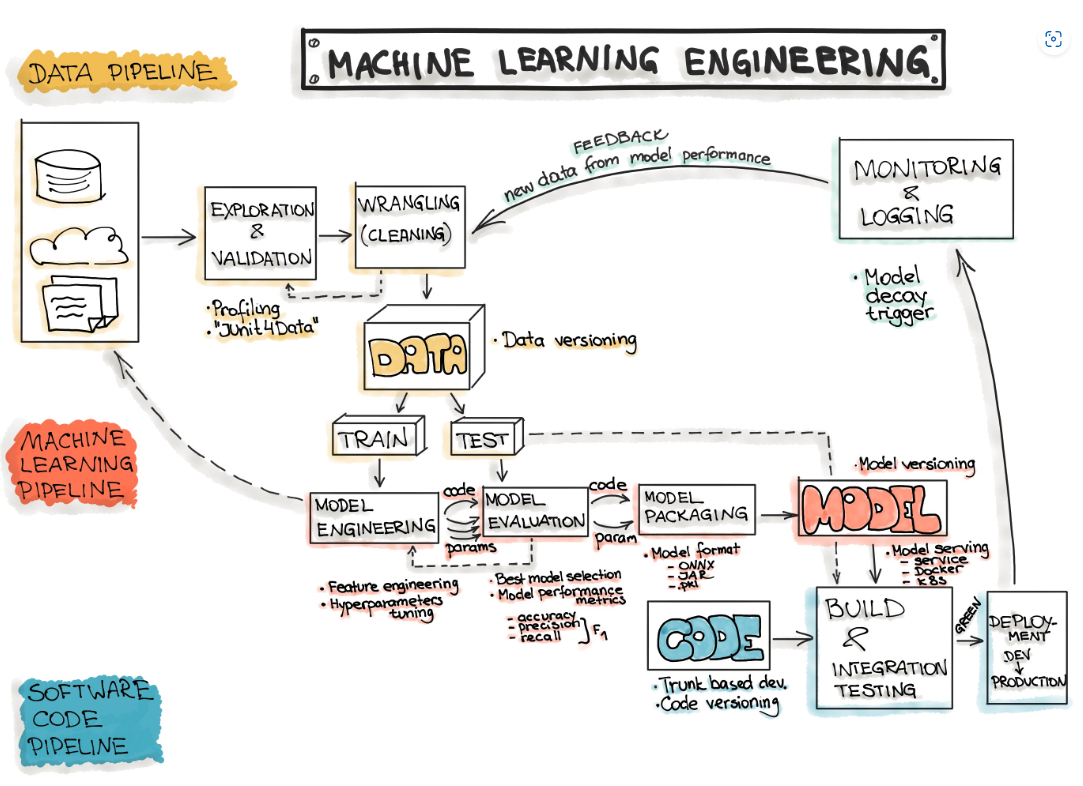

※ [출처] [MLOps.org](https://ml-ops.org/)